In [60]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [61]:
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import matplotlib.pyplot as plt
import json, pandas as pd, glob, tqdm
import gzip

def label(line, label, idx=-1, dx=0, **kwargs):
    if isinstance(line, list): line = line[0]
    x, y = line.get_data()
    plt.text(
        x[idx]+dx,
        y[idx],
        label,
        **kwargs, color=line.get_color())
    

plt.rcParams['svg.fonttype'] = 'none'

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
# plt.rcParams['font.family'] = 'Noto sans'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.directory'] = '.'
plt.rcParams['font.size'] = 16
import jax
import jax.numpy as jnp


def spatial_to_delay(r, from_=None):
    if from_ is not None:
        d = jax.vmap(lambda ri: jnp.sqrt(1e-2+((from_ - ri)**2).sum(axis=1)))(r)
        # d.shape is here (r.shape[0], from_.shape[0])
        d = d.flatten()
        return d
    else:
        d = jax.vmap(lambda ri: jnp.sqrt(1e-2+((r - ri)**2).sum(axis=1)))(r)
        d = diagonal_const(d, 1000000)
        d = d.flatten()
        return d
    
    

def diagonal_const(arr, c):
    n = arr.shape[0]
    return arr * (1 - jnp.eye(n)) + jnp.eye(n) * c

# One

In [3]:
glob.glob?

Signature:
glob.glob(
    pathname,
    *,
    root_dir=None,
    dir_fd=None,
    recursive=False,
    include_hidden=False,
)
Docstring:
Return a list of paths matching a pathname pattern.

The pattern may contain simple shell-style wildcards a la
fnmatch. Unlike fnmatch, filenames starting with a
dot are special cases that are not matched by '*' and '?'
patterns by default.

If `include_hidden` is true, the patterns '*', '?', '**'  will match hidden
directories.

If `recursive` is true, the pattern '**' will match any files and
zero or more directories and subdirectories.
File:      /usr/lib/python3.12/glob.py
Type:      function

In [296]:
!pwd

tables = {}

for f in tqdm.tqdm(glob.glob('saved/*/log.jsons*')):
    args, hparams = {}, {}
    handle = gzip.open(f, 'rt') if f.endswith('.gz') else open(f)
    try:
        with handle as fh:
            for l in fh:
                j = json.loads(l)
                t = j.pop('table')
                if t == 'args': args = j
                elif t == 'hyperparams': hparams = j
                elif t in {'epoch', 'sparse_epoch'}:
                    j.update(args)
                    j.update(hparams)
                    tables.setdefault(t, []).append(j)
    except Exception as ex:
        print()
        print(repr(ex))
        print(f)
        print()

dfs = {t: pd.DataFrame(v) for t, v in tables.items()}
epoch = dfs['epoch']


epoch['plotdim'] = epoch.apply(lambda x:
                               6 if x.netspec == 'inf' else x['ndim'], 1)

final = epoch[(epoch.i == 29) & (epoch.dt == 0.5)]
final = final[final.tgtfreq == 10]

/home/llandsmeer/repos/llandsmeer/planar_snns


/usr/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
100%|██████████████████████████████████████████████████████| 1428/1428 [00:30<00:00, 46.72it/s]


In [5]:

finalnormal
#bool( float('nan'))

NameError: name 'finalnormal' is not defined

0
∞
2
3


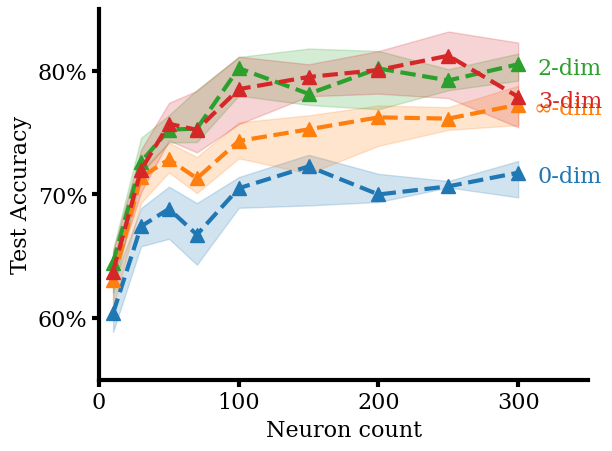

In [20]:
take = [
    '0', 'inf', '2', '3'
    ]

finalnormal = final[(final.net.isin(take)) & (True != final['sparse']) & (final.tgtfreq==10) & (final.population_freq != True) & (line != True)]

finalnormal

ERR = False



plt.xlabel('Neuron count')
if ERR:
    plt.ylim([0, 50])
    plt.ylabel('Test Error')
else:
    plt.ylabel('Test Accuracy')
    plt.ylim([55, 85])
    plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])
plt.xticks([0, 100, 200, 300])
plt.xlim([0, 350])




# for net, sub in finalnormal.groupby('netspec'):
for net in take:
    sub = finalnormal[finalnormal.netspec == net]
    sub = sub.sort_values('nhidden') # type: ignore
    low = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.25)
    high = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.75)
    sub = sub[['nhidden', 't1p']].groupby('nhidden').median()
    y = sub.t1p
    if ERR: y = 100 - y
    color = None
    # if net == '0': color = 'black'
    # elif net == 'inf': color = 'blue'
    line,  = plt.plot(sub.index, y, '^--', label=net, color=color)
    plt.fill_between(sub.index, low.t1p, high.t1p, color=line.get_color(), alpha=0.2)
    net = net.replace('inf', '∞')
    plt.text(
        sub.index.values[-1]+60,
        y.values[-1] - 0.3,
        f'{net}-dim',
        va='center',
        ha='right',
        color=line.get_color()
    )
    print(net)
    plt.tight_layout()
    plt.savefig(f'img/{net}-dim.svg')
    plt.savefig(f'img/{net}-dim.png', dpi=300)

#plt.legend(title='Network Dimensions', ncol=2)
plt.show()

In [464]:
take = [
    '0', 'inf', '2', '3'
    ]

finalnormal = final[final.net.isin(take)]

finalnormal

ERR = False



plt.xlabel('Neuron count')
if ERR:
    plt.ylim([0, 50])
    plt.ylabel('Test Error')
else:
    plt.ylabel('Test Accuracy')
    plt.ylim([55, 85])
    plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])
plt.xticks([0, 100, 200, 300])
plt.xlim([0, 350])




# for net, sub in finalnormal.groupby('netspec'):
for net in take:
    sub = finalnormal[finalnormal.netspec == net]
    sub = sub.sort_values('nhidden') # type: ignore
    low = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.25)
    high = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.75)
    sub = sub[['nhidden', 't1p']].groupby('nhidden').median()
    y = sub.t1p
    if ERR: y = 100 - y
    color = None
    # if net == '0': color = 'black'
    # elif net == 'inf': color = 'blue'
    line,  = plt.plot(sub.index, y, '^--', label=net, color=color)
    net = net.replace('inf', '∞')
    plt.text(
        sub.index.values[-1]+60,
        y.values[-1] - 0.3,
        f'{net}-dim',
        va='center',
        ha='right',
        color=line.get_color()
    )
    print(net)
    
plt.tight_layout()
plt.savefig(f'img/nofill-dim.svg')
plt.savefig(f'img/nofill-dim.png', dpi=300)

0
∞
2
3


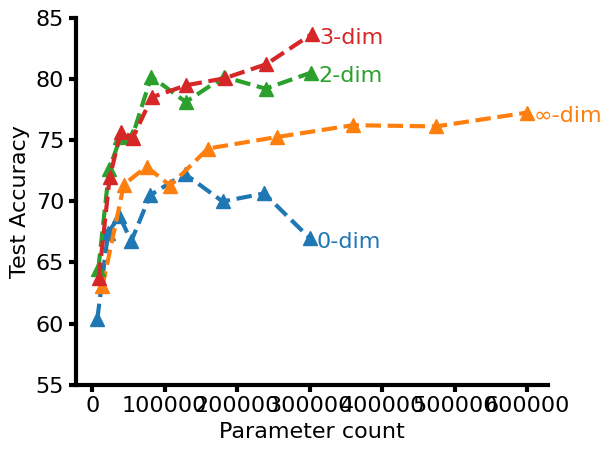

In [417]:
take = [
    '0', 'inf', '2', '3'
    ]

#finalnormal = final[final.net.isin(take)]
finalnormal = final[(final.net.isin(take))  & (final['sparse']!= final['sparse']) &
(final.tgtfreq==10) & (final.population_freq != True) & (final.line != True) &
(final.adex != final.adex)] #& (final.tag == 'default')]


finalnormal


plt.xlabel('Parameter count')
plt.ylabel('Test Accuracy')
plt.ylim([55, 85])
# plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])
# plt.xticks([0, 100, 200, 300])
# plt.xlim([0, 350])




# for net, sub in finalnormal.groupby('netspec'):
for net in take:
    sub = finalnormal[finalnormal.netspec == net]
    sub = sub.sort_values('nhidden') # type: ignore
    low = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.25)
    high = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.75)
    sub = sub[['nhidden', 't1p']].groupby('nhidden').median()
    y = sub.t1p
    color = None
    # if net == '0': color = 'black'
    # elif net == 'inf': color = 'blue'
    neurons = sub.index.values
    if net == '0':
        params = neurons * (neurons - 1) + 700 * neurons
    elif net == 'inf':
        params = 2 * neurons * (neurons - 1) + 2 * 700 * neurons
    else:
        params = 700 * neurons + int(net)*700 + neurons * (neurons - 1) + neurons * int(net)
    line,  = plt.plot(params, y, '^--', label=net, color=color)
    net = net.replace('inf', '∞')
    plt.text(
        params[-1]+10000,
        y.values[-1] - 0.3,
        f'{net}-dim',
        va='center',
        ha='left',
        color=line.get_color()
    )
    print(net)
    
plt.tight_layout()
plt.savefig(f'img/nofill-params-dim.svg')
plt.savefig(f'img/nofill-params-dim.png', dpi=300)

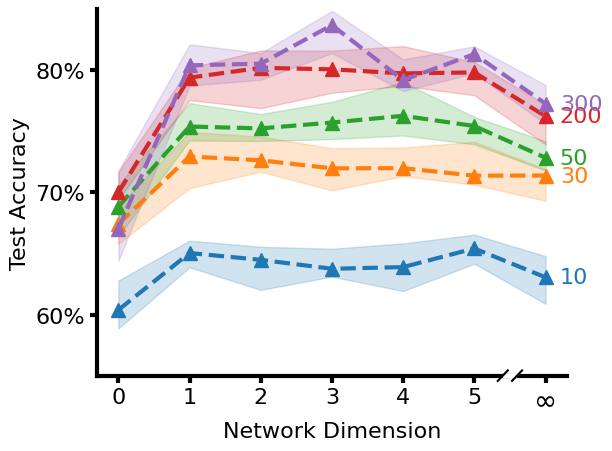

In [419]:
import matplotlib.transforms as mtrans

take = [
    '0', '1', '2', '3', '4', '5', 'inf'
    ]
ax = plt.gca()

finalnormal = final[(final.net.isin(take))  & (final['sparse']!= final['sparse']) &
(final.tgtfreq==10) & (final.population_freq != True) & (final.line != True) &
(final.adex != final.adex)] #& (final.tag == 'default')]

take_nh = [ 10, 30, 50, 200, 300]

plt.ylabel('Test Accuracy')
plt.ylim([55, 85])
plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])

ticks = [0, 1, 2, 3, 4, 5, 6]
labels = [0, 1, 2, 3, 4, 5, '∞']
ax.set_xticks(ticks)
text_labels = ax.set_xticklabels(labels)

text_labels[-1].set_fontsize(20)

for nh, sub in finalnormal.groupby('nhidden'):
    if take_nh and nh not in take_nh: continue
    sub = sub.sort_values('plotdim')
    low = sub[['plotdim', 't1p']].groupby('plotdim').quantile(0.25)
    high = sub[['plotdim', 't1p']].groupby('plotdim').quantile(0.75)
    sub = sub[['plotdim', 't1p']].groupby('plotdim').median()
    line,  = plt.plot(sub.index, sub.t1p, '^--')
    plt.fill_between(sub.index, low.t1p, high.t1p, color=line.get_color(), alpha=0.2)
    plt.text(
        sub.index.values[-1]+0.2,
        sub.t1p.values[-1],
        f'{nh}',
        va='center',
        ha='left',
        color = line.get_color()
    )

plt.gcf().canvas.draw()
x_positions = [5.4, 5.6]
y_data = ax.get_ylim()[0]
L_px = 15.0
half = L_px / 2.0
d = half / np.sqrt(2.0)
to_display = ax.transData.transform
to_data = ax.transData.inverted().transform
to_display = ax.transData.transform
to_data = ax.transData.inverted().transform
ax.plot([min(x_positions)+0.03, -0.03+max(x_positions)], [y_data, y_data], color='w', linewidth=3, clip_on=False, zorder=10)
for x0 in x_positions:
    x_disp, y_disp = to_display((x0, y_data))
    p1_disp = (x_disp - d, y_disp - d)
    p2_disp = (x_disp + d, y_disp + d)
    p1_data = to_data(p1_disp)
    p2_data = to_data(p2_disp)
    ax.plot([p1_data[0], p2_data[0]], [p1_data[1], p2_data[1]],
            color='k', linewidth=1.5, clip_on=False, zorder=100)
plt.xlabel('Network Dimension')
plt.tight_layout()
plt.savefig('img/netw.svg')
plt.savefig('img/netw.png')
plt.show()

# Eps

In [86]:
finaleps = (epoch[(epoch.i == 49) & (epoch.tag == 'fixed-eps')]).copy()

finaleps['eps'] = finaleps['netspec'].str.split('e').str[1].astype(float)
finaleps = finaleps.loc[:, finaleps.nunique() > 1]
finaleps = finaleps.drop('netspec', axis='columns').drop('net', axis='columns').drop('id', axis='columns')
# print(finaleps.groupby(['nhidden', 'plotdim', 'eps']).count())
low = finaleps.groupby(['nhidden', 'plotdim', 'eps']).quantile(0.5).reset_index().drop('seed', axis='columns')
high = finaleps.groupby(['nhidden', 'plotdim', 'eps']).quantile(0.75).reset_index().drop('seed', axis='columns')
finaleps = finaleps.groupby(['nhidden', 'plotdim', 'eps']).median().reset_index().drop('seed', axis='columns')
#finaleps = finaleps[finaleps.nhidden == 10].groupby('net').median().sort_values('netspec')

# 10, 30, 50
#for n in [10, 30, 50]:
for n in [10, 50]:
    X =finaleps[finaleps.nhidden == n]
    L =low[low.nhidden == n]
    H =high[high.nhidden == n]
    for d in [2, 3]:
        label(plt.plot(
            100+100*x[x.plotdim==d].eps,
            x[x.plotdim==d].t1p,
            '-'),
            f'{d}d, n={n}', dx=4)
        plt.fill_between(
            100+100*x[x.plotdim==d].eps.values,
            l[l.plotdim==d].t1p.values,
            h[h.plotdim==d].t1p.values, alpha=0.3, zorder=-100)

        
ml = np.array([100, 150, 200])
plt.xticks(ml, [f'{x}%' for x in ml])

#plt.legend()
plt.ylabel('Test accuracy')
plt.xlabel('Max length w.r.t. straight line')

plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])

plt.tight_layout()
#plt.savefig('img/eps.svg')
#plt.savefig('img/eps.png')


AttributeError: 'DataFrame' object has no attribute 'plotdim'

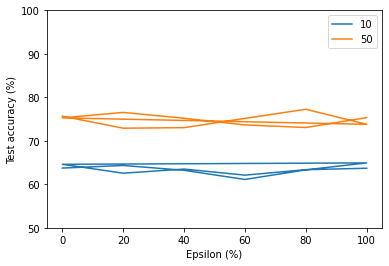

0.0
0.2
0.4
0.6
0.8
1.0


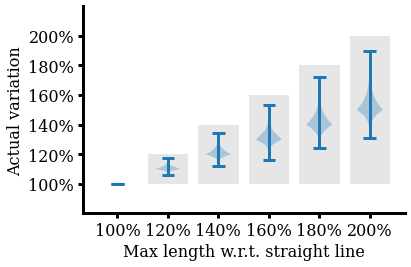

In [452]:
finaleps
finaleps = (epoch[(epoch.i == 49) & (epoch.tag == 'fixed-eps')]).copy()
finaleps['eps'] = finaleps['netspec'].str.split('e').str[1].astype(float)
finaleps = finaleps.loc[:, finaleps.nunique() > 1]

dd = dict()
for _idx, row in finaleps.iterrows():
    fns = glob.glob(f'saved/*{row.id}*/epoch_*049.npz')
    if not fns:
        continue
    if row.plotdim != 2:
        continue
    fn, = fns
    d = np.load(fn)
    ieps = 100 + 100 * row.eps * (0.5 + 0.5 * np.tanh(d['ierr']))
    reps = 100 + 100 * row.eps * (0.5 + 0.5 * np.tanh(d['rerr']))
    if row.eps not in dd:
        dd[row.eps] = []
    dd[row.eps].extend(reps)
    
plt.bar(
    np.arange(1, len(dd)+1),
    100*np.array(sorted(dd.keys())),
    bottom=100,
    color='0.9')

plt.violinplot(
    [dd[k] for k in sorted(dd.keys())]
);

for i, k in enumerate(sorted(dd.keys()), 1):
    print(k)

plt.xticks(np.arange(1, len(dd)+1), [f'{100+x*100:.0f}%' for x in sorted(dd.keys())])
# plt.yticks([100, 150, 200], ['100', '150%', '200%'])
plt.yticks([100+x*100 for x in sorted(dd.keys())],
           [f'{100+x*100:.0f}%' for x in sorted(dd.keys())])

#plt.xlabel('Epsilon')
plt.ylabel('Actual variation')
plt.xlabel('Max length w.r.t. straight line')

plt.ylim(80, 220)


#plt.

#trace = [
#    dict(np.load(x))
#    for x in 
#    sorted(x for x in glob.glob(
        # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/saved/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
#        'saved/*3e1*/epoch_*.npz'
#    ) if not 'read' in x)
##]
plt.tight_layout()
plt.savefig('img/epsuse.svg')
plt.savefig('img/epsuse.png')

# Epsilon v2 

In [22]:
epoch[epoch.i == 49]

,id,i,t1p,t3p,t1p_train,t3p_train,net,nhidden,batch_size,load_limit,...,delaysigma,possigma,tgtfreq,ninput,noutput,netspec,ndim,population_freq,tag,plotdim
199,8b1ae5e3-0c4e-4620-a0a1-510a8435f0d7,49,58.420139,83.998840,79.582329,96.048676,2e0.60,10,32,None,...,1.0,20.0,10.0,700,20,2e0.60,2.0,False,fixed-eps,2.0
459,b9764e45-2a27-4d9a-bf72-fe9079d4ec9b,49,62.803822,87.254051,79.627403,94.681488,3e1.00,10,32,None,...,1.0,20.0,10.0,700,20,3e1.00,3.0,False,fixed-eps,3.0
651,b32d6be2-1eca-4b36-93af-031b1e1bd029,49,63.961231,87.847221,78.380409,95.898438,2e0.40,10,32,None,...,1.0,20.0,10.0,700,20,2e0.40,2.0,False,fixed-eps,2.0
1031,656fd55d-9e72-4c0e-b7a6-d29b55f4d82a,49,70.124428,91.059029,96.484375,99.023438,3e0.60,30,32,None,...,1.0,20.0,10.0,700,20,3e0.60,3.0,False,fixed-eps,3.0
1231,e1f48cd0-52f5-4658-869f-a2a93f41dbc6,49,73.654518,91.001160,96.003609,99.804688,3e1.00,50,32,None,...,1.0,20.0,10.0,700,20,3e1.00,3.0,False,fixed-eps,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24108,b06be5d3-14e7-4bfd-9477-9c1386b5289d,49,62.123840,86.805557,81.730766,96.003609,3e0.60,10,32,None,...,1.0,20.0,10.0,700,20,3e0.60,3.0,False,fixed-eps,3.0
24248,b94e229f-c5a4-4ee6-924f-cea611b1796e,49,65.104164,89.308449,84.014420,95.808296,3e0.00,10,32,None,...,1.0,20.0,10.0,700,20,3e0.00,3.0,False,fixed-eps,3.0
24358,7f9d718b-e34a-4728-a568-baa52cb3b40d,49,72.598381,92.925346,95.612984,99.759613,3e0.20,30,32,None,...,1.0,20.0,10.0,700,20,3e0.20,3.0,False,fixed-eps,3.0
24438,d19914d7-71ee-4909-bdf4-35ec6fce31c5,49,73.480904,92.491318,95.808296,99.609375,2e1.00,30,32,None,...,1.0,20.0,10.0,700,20,2e1.00,2.0,False,fixed-eps,2.0


In [23]:
# 

# Positions

In [356]:
# glob.glob('saved/*/epoch_00000000.npz')
df = epoch[
    (epoch['ndim']==2) &
    (epoch['i']==29)
].copy()

df['ntrace'] = df['id'].apply(lambda ident:  len(glob.glob(f'saved/*{ident}*/epoch_*.npz')) )

df = df[(df.ntrace > 10) & (df.netspec.apply(lambda x: 'e' not in x))]
df

,id,i,t1p,t3p,t1p_train,t3p_train,net,nhidden,batch_size,load_limit,...,possigma,tgtfreq,population_freq,tag,ninput,noutput,netspec,ndim,plotdim,ntrace
29,f0f9c26e-b745-46d9-8c4c-557912acf2c8,29,61.255787,86.892365,79.191704,95.853363,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
5905,a7a94219-e478-4aa7-adca-42bf1f9d5a32,29,65.046303,88.642937,81.911057,96.048676,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
10656,3302e3fc-86ad-4aca-a73a-db7daf882c58,29,65.842018,88.165504,79.627403,95.658051,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
10686,f0271c0f-43d3-4afa-97eb-a2c090efdcea,29,61.863422,86.979164,77.854568,95.853363,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
13503,cd766c3e-5c55-4d4d-a990-29dcce914294,29,63.700813,85.648148,78.665863,94.155647,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
14385,e27c9c06-d211-4bec-a88f-96af1634360c,29,68.359375,90.697342,78.350357,95.898438,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
15915,fe8405e5-0875-40c8-8f66-3c68bd728ac1,29,59.230328,84.982643,77.193512,95.072113,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
17714,8345f079-c669-48e7-80e2-0a17e9368a7c,29,61.168980,85.966438,79.627403,95.117188,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
20807,dda0997d-0e5f-42c2-9efa-1b69be69264d,29,66.637733,87.123840,81.971153,97.025238,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
22281,7b2d6415-d871-4bce-a771-32d1d87a70a9,29,58.405674,85.315399,79.236778,94.831734,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60


In [106]:
#'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_d57726df-ed90-4fa3-a28a-f9d6c8288b4c/epoch_00000000.npz'
ident = 'f0f9c26e-b745-46d9-8c4c-557912acf2c8'
trace = [
    dict(np.load(x))
    for x in 
    sorted(x for x in glob.glob(
        # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/savd/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
        f'saved/*{ident}*/epoch_*.npz'
    ) if not 'read' in x)
]

columns = trace[0].keys()

trace = {
    k: np.array([x[k] for x in trace]) for k in columns
}

IndexError: list index out of range

<Figure size 432x288 with 0 Axes>

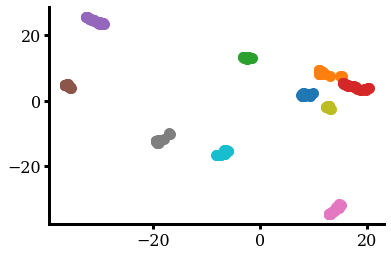

<Figure size 432x288 with 0 Axes>

In [358]:
for i in range(10):
    x = trace['ipos'][:,i,0]
    y = trace['ipos'][:,i,1]
    plt.plot(x, y, 'o--')
plt.figure()

In [359]:
# for i in range(10):
#     x = trace['ipos'][:,i,0] - trace['ipos'][0,i,0]
#     y = trace['ipos'][:,i,1] - trace['ipos'][0,i,1]
#     plt.plot(x, y, 'o--')

Text(0, 0.5, 'Weight')

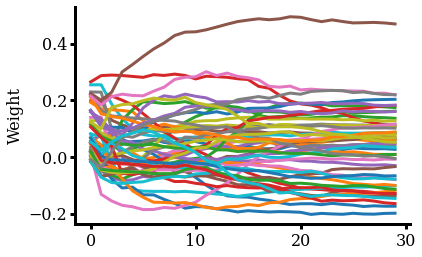

In [360]:
for i in range(10):
    plt.plot(trace['rw'][:,i,(i+1)%10])
    plt.plot(trace['rw'][:,i,(i+2)%10])
    plt.plot(trace['rw'][:,i,(i+3)%10])
    plt.plot(trace['rw'][:,i,(i+4)%10])
    plt.plot(trace['rw'][:,i,(i+5)%10])
plt.ylabel('Weight')

In [361]:
EPS = 0.4
import numpy as np
for i in range(100):
    plt.plot(100 * EPS * (0.5 + 0.5 * np.tanh(trace['ierr'][:,i])))
plt.ylabel('Epsilon (%)')
plt.xlabel('Epoch')

KeyError: 'ierr'


# Distance plot

In [362]:
trace = [
    dict(np.load(x))
    for x in 
    sorted(x for x in glob.glob(
        # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/saved/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
        '/tmp/saved/*3e1*/epoch_*.npz'
    ) if not 'read' in x)
]

columns = trace[0].keys()

trace = {
    k: np.array([x[k] for x in trace]) for k in columns
}

IndexError: list index out of range

In [32]:


X = trace['rw'][-1].flatten()

Y = spatial_to_delay(trace['rpos'][-1])

m = Y != Y.max()

print(X.shape)
print(Y.shape)

plt.scatter(Y[m], X[m])
plt.axhline(0)
plt.xlabel('Distance')
plt.ylabel('Weight')


TypeError: list indices must be integers or slices, not str

# E-I balance

''

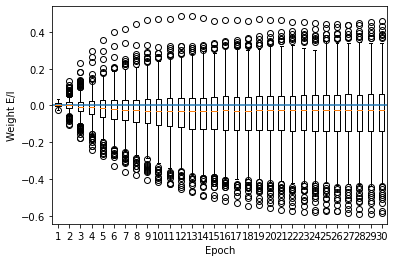

In [35]:

trace = [
    dict(np.load(x))
    for x in 
    sorted(x for x in glob.glob(
        'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/saved/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
        # '/tmp/saved/*3e1*/epoch_*.npz'
    ) if not 'read' in x)
]

columns = trace[0].keys()

trace = {
    k: np.array([x[k] for x in trace]) for k in columns
}

X = trace['rw']
X = X[:,~jnp.eye(X.shape[1], dtype=bool)]

plt.boxplot(X.T)
plt.axhline(0)
plt.xlabel('Epoch')
plt.ylabel('Weight E/I')
;

# YY

In [173]:
from io import StringIO


In [456]:
# 0 and Fixed Delays same param count
csv_data = '''0,1,2,3,4,5,6,7
neurons,10,15,20,25,30,45,60
nparams_0,70,105,140,175,210,315,420
nparams_inf,140,210,280,350,420,630,840
nparams_2d,104,149,194,239,284,419,554
nparams_3d,121,171,221,271,321,471,621
nparams_4d,138,193,248,303,358,523,688
t1p_0d,70.078125,68.535155,70.195315,71.40625,71.5625,81.45508000000001,79.71679499999999
t1p_fd,70.888675,80.29297,86.18163999999999,82.480465,81.2793,88.242185,90.6738275
t1p_inf,77.41211,82.421875,85.49805,86.93359,90.3125,90.634765,91.865235
t1p_2d,76.40625,78.515625,84.23828,85.283205,89.492185,90.75195,93.1445325
t1p_3d,68.99414,79.25781,80.99609,82.96875,88.22266,89.13086,90.4394525
t1p_4d,65.361328,74.56055,86.1132825,83.79883000000001,87.49023500000001,88.867185,90.839845
'''.strip()

df = pd.read_csv(StringIO(csv_data))
df = df.set_index('0', ).T
df

0,neurons,nparams_0,nparams_inf,nparams_2d,nparams_3d,nparams_4d,t1p_0d,t1p_fd,t1p_inf,t1p_2d,t1p_3d,t1p_4d
1,10.0,70.0,140.0,104.0,121.0,138.0,70.078125,70.888675,77.412110,76.406250,68.994140,65.361328
2,15.0,105.0,210.0,149.0,171.0,193.0,68.535155,80.292970,82.421875,78.515625,79.257810,74.560550
3,20.0,140.0,280.0,194.0,221.0,248.0,70.195315,86.181640,85.498050,84.238280,80.996090,86.113282
4,25.0,175.0,350.0,239.0,271.0,303.0,71.406250,82.480465,86.933590,85.283205,82.968750,83.798830
5,30.0,210.0,420.0,284.0,321.0,358.0,71.562500,81.279300,90.312500,89.492185,88.222660,87.490235
6,45.0,315.0,630.0,419.0,471.0,523.0,81.455080,88.242185,90.634765,90.751950,89.130860,88.867185
7,60.0,420.0,840.0,554.0,621.0,688.0,79.716795,90.673828,91.865235,93.144532,90.439453,90.839845


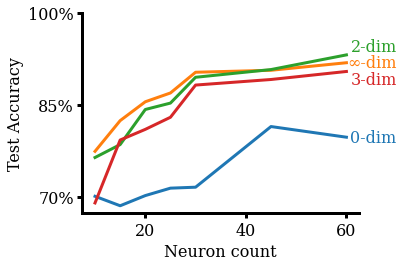

In [288]:

#plt.plot(df.neurons, df.t1p_fd)
label(plt.plot(df.neurons, df.t1p_0d),  '0-dim', ha='right', va='center', dx=10)
label(plt.plot(df.neurons, df.t1p_inf), '∞-dim', ha='right', va='center', dx=10)
label(plt.plot(df.neurons, df.t1p_2d),  '2-dim', ha='right', va='bottom', dx=10)
label(plt.plot(df.neurons, df.t1p_3d),  '3-dim', ha='right', va='top',    dx=10)
#plt.plot(df.neurons, df.t1p_4d)

plt.ylabel('Test Accuracy')
plt.yticks([70, 85, 100], [f'{x}%' for x in [70, 85, 100]])
plt.xlabel('Neuron count')

plt.tight_layout()
plt.savefig('img/yy0.png')
plt.savefig('img/yy0.svg')


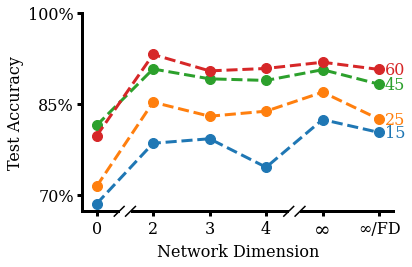

In [287]:
for nh in 15, 25, 45, 60:
    x = '0', '2', '3', '4', '∞', '∞/FD'
    y = df[['t1p_0d',  't1p_2d', 't1p_3d', 't1p_4d', 't1p_inf', 't1p_fd']][df.neurons == nh].values[0]
    line, = plt.plot(np.arange(len(x)), y, 'o--')
    plt.text(
        len(x)-1+.1,
        y[-1],
        f'{nh}',
        va='center',
        ha='left',
        color = line.get_color()
    )

ax = plt.gca()

ax.set_xticks(np.arange(len(x)))
text_labels = ax.set_xticklabels(x)
text_labels[-2].set_fontsize(20)
plt.ylabel('Test Accuracy')
plt.yticks([70, 85, 100], [f'{x}%' for x in [70, 85, 100]])

a = plt.ylim()

plt.gcf().canvas.draw()
y_data = ax.get_ylim()[0]

for x_positions in [
        [0.4, 0.6],
        [3.4, 3.6]
    ]:
    L_px = 15.0
    half = L_px / 2.0
    d = half / np.sqrt(2.0)
    to_display = ax.transData.transform
    to_data = ax.transData.inverted().transform
    to_display = ax.transData.transform
    to_data = ax.transData.inverted().transform
    ax.plot([min(x_positions)+0.03, -0.03+max(x_positions)], [y_data, y_data], color='w', linewidth=3, clip_on=False, zorder=10)
    for x0 in x_positions:
        x_disp, y_disp = to_display((x0, y_data))
        p1_disp = (x_disp - d, y_disp - d)
        p2_disp = (x_disp + d, y_disp + d)
        p1_data = to_data(p1_disp)
        p2_data = to_data(p2_disp)
        ax.plot([p1_data[0], p2_data[0]], [p1_data[1], p2_data[1]],
                color='k', linewidth=1.5, clip_on=False, zorder=100)

plt.ylim(a)
plt.xlabel('Network Dimension')

plt.tight_layout()
plt.savefig('img/yy1.png')
plt.savefig('img/yy1.svg')

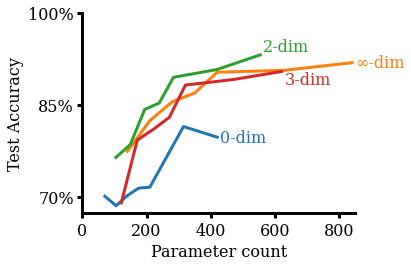

In [463]:
#spatial
#0	neurons	nparams_0	nparams_inf	nparams_2d	nparams_3d	nparams_4d	t1p_0d	t1p_fd	t1p_inf	t1p_2d	t1p_3d	t1p_4d


#plt.plot(df.neurons, df.t1p_fd)
label(plt.plot(df.nparams_0, df.t1p_0d),  '0-dim', ha='left', va='center', dx=10)
label(plt.plot(df.nparams_inf, df.t1p_inf), '∞-dim', ha='left', va='center', dx=10)
label(plt.plot(df.nparams_2d, df.t1p_2d),  '2-dim', ha='left', va='bottom', dx=10)
label(plt.plot(df.nparams_3d, df.t1p_3d),  '3-dim', ha='left', va='top',    dx=10)
#plt.plot(df.neurons, df.t1p_4d)

plt.ylabel('Test Accuracy')
plt.yticks([70, 85, 100], [f'{x}%' for x in [70, 85, 100]])
plt.xlabel('Parameter count')
plt.xlim(0, 850)

plt.tight_layout()
plt.savefig('img/yy0params.png')
plt.savefig('img/yy0params.svg')

# Grid

In [80]:
finaleps = (epoch[(epoch.i == 29) & (epoch.net.apply(lambda x: 'g' in x))]).copy()

finaleps['eps'] = finaleps['netspec'].str.split('g').str[1].astype(float)
finaleps = finaleps.loc[:, finaleps.nunique() > 1]
finaleps = finaleps.drop('netspec', axis='columns').drop('net', axis='columns').drop('id', axis='columns')
# print(finaleps.groupby(['nhidden', 'plotdim', 'eps']).count())
low = finaleps.groupby(['nhidden', 'eps']).quantile(0.5).reset_index().drop('seed', axis='columns')
high = finaleps.groupby(['nhidden', 'eps']).quantile(0.75).reset_index().drop('seed', axis='columns')
finaleps = finaleps.groupby(['nhidden', 'eps']).median().reset_index().drop('seed', axis='columns')
#finaleps = finaleps[finaleps.nhidden == 10].groupby('net').median().sort_values('netspec')

# 10, 30, 50
#for n in [10, 30, 50]:

# display(finaleps)

for n in [10, 30, 50, 300]:
    X =finaleps[finaleps.nhidden == n]
    L =low[low.nhidden == n]
    H =high[high.nhidden == n]
    label(line := plt.plot(
        100+100*X.eps,
        X.t1p,
        '-'),
        f'n={n}', dx=4)
    plt.fill_between(
        100+100*X.eps.values,
        L.t1p.values,
        H.t1p.values, alpha=0.3, zorder=-100)
    reference = finalnormal[(finalnormal.net == str(2)) &(finalnormal.nhidden == n)].t1p.median()
    plt.plot(
        [95, 100], 
        [reference, reference],
        ls='-',
        color=line[0].get_color(),
        zorder=100,
        clip_on=False
    )
        
ml = np.array([100, 125, 150])
plt.xticks(ml, [f'{x}%' for x in ml])

#plt.legend()
plt.ylabel('Test accuracy')
plt.xlabel('Max length w.r.t. straight line')

plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])

plt.xlim(100, 150)

plt.tight_layout()
plt.savefig('img/grid.svg')
plt.savefig('img/grid.png')

KeyError: "['netspec'] not found in axis"

In [393]:
epoch.net

0             2
1             2
2             2
3             2
4             2
          ...  
41236    2g0.30
41237    2g0.30
41238    2g0.30
41239    2g0.30
41240    2g0.30
Name: net, Length: 41241, dtype: object

# Remap it back

# Paths of a line

In [100]:

ident = '20251126_d2_h30_lr0.01_llNone_dt0.05_2ad67336-d388-4c2f-94af-2ada4f56c1d2'
trace = [
    dict(np.load(x))
    for x in 
    sorted(x for x in glob.glob(
        # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/savd/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
        f'saved/{ident}/epoch_*.npz'
    ) if not 'read' in x)
]

columns = trace[0].keys()

trace = {
    k: np.array([x[k] for x in trace]) for k in columns
}

In [104]:
x = trace['ipos'][:,:,0]
y = trace['ipos'][:,:,1]

xr = trace['rpos'][:,:,0]
yr = trace['rpos'][:,:,1]

print(x.shape)

(21, 700)


(21, 700)

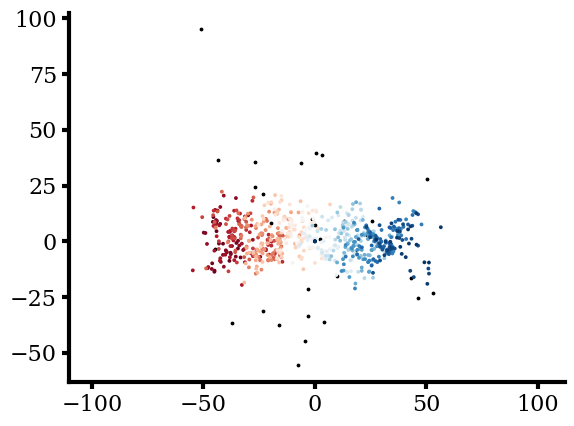

In [105]:
epoch = -1
plt.scatter(xr[epoch], yr[epoch], color='black', s=3)
plt.scatter(x[epoch], y[epoch], c=np.arange(700), s=3, cmap='RdBu')
plt.axis('equal')
x.shape

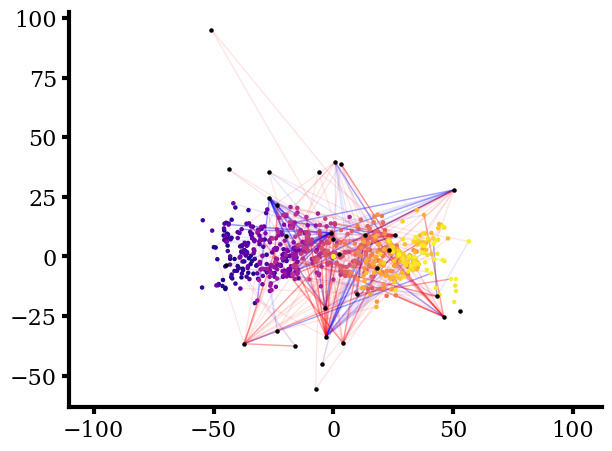

In [128]:
epoch = -1

w = trace['iw'][-1]
wr = trace['rw'][-1]

for ii, jj in zip(*np.where(w > 2)):
    plt.plot([ x[epoch, jj], xr[epoch, ii], ], [ y[epoch, jj], yr[epoch, ii] ], color='blue', lw=1, alpha=0.3)
for ii, jj in zip(*np.where(w < -2)):
    plt.plot([ x[epoch, jj], xr[epoch, ii], ], [ y[epoch, jj], yr[epoch, ii] ], color='red', lw=1, alpha=0.3)
for ii, jj in zip(*np.where(w > 1.5)):
    plt.plot([ x[epoch, jj], xr[epoch, ii], ], [ y[epoch, jj], yr[epoch, ii] ], color='blue', lw=1, alpha=0.1)
for ii, jj in zip(*np.where(w < -1.5)):
    plt.plot([ x[epoch, jj], xr[epoch, ii], ], [ y[epoch, jj], yr[epoch, ii] ], color='red', lw=1, alpha=0.1)
    
for ii, jj in zip(*np.where(wr > 2)):
    plt.plot([ xr[epoch, jj], xr[epoch, ii], ], [ yr[epoch, jj], yr[epoch, ii] ], color='blue', lw=1, alpha=0.3)
for ii, jj in zip(*np.where(wr < -2)):
    plt.plot([ xr[epoch, jj], xr[epoch, ii], ], [ yr[epoch, jj], yr[epoch, ii] ], color='red', lw=1, alpha=0.3)
for ii, jj in zip(*np.where(wr > 1.5)):
    plt.plot([ xr[epoch, jj], xr[epoch, ii], ], [ yr[epoch, jj], yr[epoch, ii] ], color='blue', lw=1, alpha=0.1)
for ii, jj in zip(*np.where(wr < -1.5)):
    plt.plot([ xr[epoch, jj], xr[epoch, ii], ], [ yr[epoch, jj], yr[epoch, ii] ], color='red', lw=1, alpha=0.1)
    
plt.scatter(x[epoch], y[epoch], c=np.arange(700), s=5, cmap='plasma', zorder=10)
plt.scatter(xr[epoch], yr[epoch], color='black', s=5, zorder=10)

plt.axis('equal')

plt.tight_layout()
plt.savefig('img/somat.svg')
plt.savefig('img/somat.png')

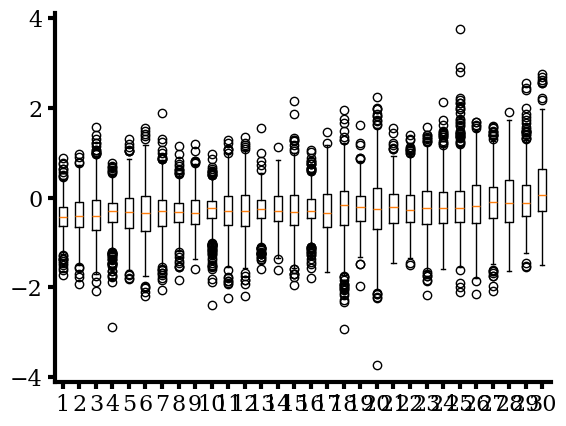

In [87]:
plt.boxplot(w[w.sum(1).argsort()].T);
#ww = [x[np.abs(x) > 2] for x in w]
#plt.boxplot(ww);

[15,
 23,
 5,
 5,
 4,
 3,
 3,
 2,
 2,
 2,
 2,
 3,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 3,
 1,
 6,
 14,
 11]

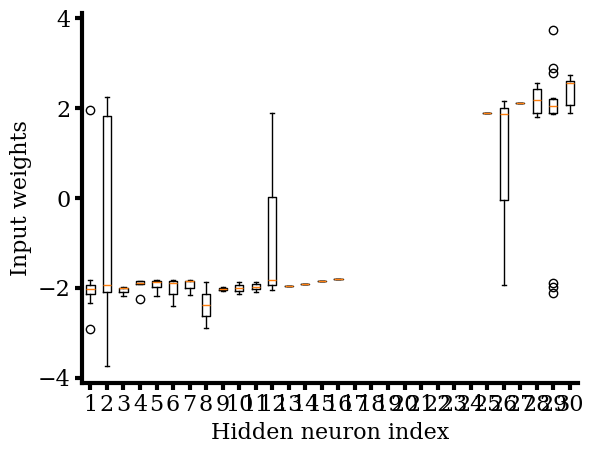

In [98]:
ww = sorted([x[np.abs(x) > 1.8] for x in w], key=lambda x: sum(x))
plt.boxplot(ww);
plt.ylabel('Input weights')
plt.xlabel('Hidden neuron index')
list(map(len, ww))

# sparse

In [63]:

x = dfs['sparse_epoch']
x[x.i==29]

,id,i,t1p,t3p,t1p_sp,t3p_sp,t1p_train,t3p_train,net,nhidden,...,possigma,tgtfreq,population_freq,tag,line,sparse,ninput,noutput,netspec,ndim
29,d4138fdd-78b7-439e-a414-c845e4673b91,29,77.285881,94.386574,76.461227,93.561928,96.153847,100.000000,3,300,...,20.0,10.0,False,sparse_dev,False,0.60,700,20,3,3
96,1948df4b-5ff7-43a7-af85-d6ef17bd92c6,29,74.609375,93.981483,76.750580,95.081024,94.831734,99.759613,3,300,...,20.0,10.0,False,sparse_dev,False,0.30,700,20,3,3
126,ebc0dbf9-f845-4568-bb7e-84bfa6cc4d12,29,74.638313,91.435188,76.287621,92.563660,96.243988,99.609375,3,300,...,20.0,10.0,False,sparse_dev,False,0.70,700,20,3,3
156,08dc559a-ba06-4257-b540-33f8f4168006,29,78.486687,92.954285,79.673035,93.851273,93.464546,100.000000,3,300,...,20.0,10.0,False,sparse_dev,False,0.50,700,20,3,3
186,ed26562d-46e3-4733-8c22-ec939b1071d5,29,76.634842,94.169563,76.750580,96.281830,85.486778,98.242188,3,300,...,20.0,10.0,False,sparse_dev,False,0.10,700,20,3,3
216,4c836f12-ae64-4c8a-8a2d-9f2e3b213247,29,77.054398,93.359375,77.575233,93.272568,97.806488,99.804688,3,300,...,20.0,10.0,False,sparse_dev,False,0.90,700,20,3,3
246,ff8f2a66-dbbe-49d8-a487-1dd1ef2bd238,29,75.245949,94.343178,74.623840,92.910881,92.142426,99.023438,3,300,...,20.0,10.0,False,sparse_dev,False,0.20,700,20,3,3
276,86c797cc-bd52-48b8-a937-3b1b57f8624e,29,65.957756,88.614006,26.851852,54.267941,67.833534,91.511421,3,300,...,20.0,10.0,False,sparse_dev,False,0.01,700,20,3,3
306,dc59f068-8c4c-4402-aa39-8426b0fa6770,29,75.477432,93.070023,76.779518,93.200233,95.612984,99.804688,3,300,...,20.0,10.0,False,sparse_dev,False,0.40,700,20,3,3


In [77]:
x = dfs['sparse_epoch']

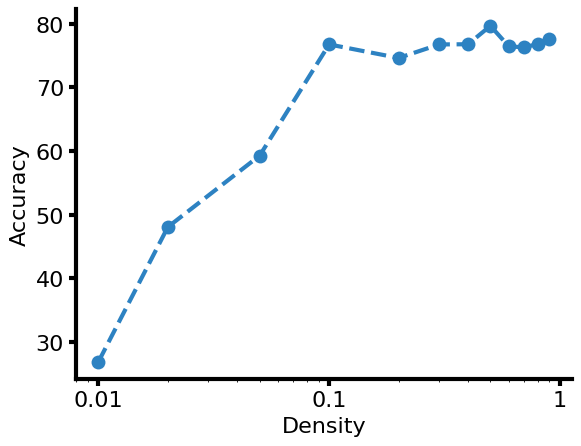

In [46]:
x = dfs['sparse_epoch']

if 1:
    x = x[x.i==29]
else:
    # while waiting for simulation finish
    x = x[((x.groupby('id').i.max()[x.id].values==x.i) & (x['sparse'] < 0.1)) | (x.i == 29)]

#display(x)

x = x.sort_values('sparse')
s = x['sparse']
# t = x.t1p
# plt.plot(s, t, 'o--', color='#1f5f8f4c', markeredgecolor='none')
ts = x.t1p_sp
plt.plot(s, ts, 'o--', color='#2d82c2ff', markeredgecolor='none')
#plt.ylim(60, 100)
#plt.xlim(0, 1)

plt.xscale('log')
plt.xlabel('Density')
plt.ylabel('Accuracy')
plt.xticks([0.01, 0.1, 1], [0.01, 0.1, 1])


plt.savefig('img/sparse_all.png')
plt.savefig('img/sparse_all.svg')

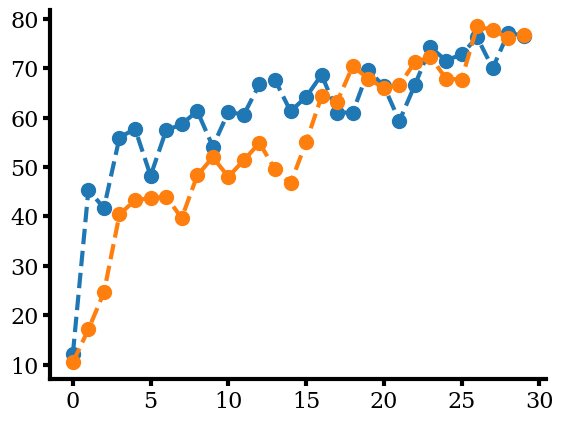

In [16]:
ident = 'ed26562d-46e3-4733-8c22-ec939b1071d5'

x = dfs['sparse_epoch']
x = x[x['id'] == ident]
plt.plot(x.i, x.t1p, 'o--')
plt.plot(x.i, x.t1p_sp, 'o--')

plt.savefig('img/sparse0.1_epochs.png')
plt.savefig('img/sparse0.1_epochs.svg')

In [90]:
ident = '20251126_d2_h30_lr0.01_llNone_dt0.05_2ad67336-d388-4c2f-94af-2ada4f56c1d2'

ident = 'ed26562d-46e3-4733-8c22-ec939b1071d5'

trace = [
    dict(np.load(x))
    for x in 
    sorted(x for x in glob.glob(
        # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/savd/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
        f'saved/*{ident}*/epoch_*.npz'
    ) if not 'read' in x)
]

columns = trace[0].keys()

trace = {
    k: np.array([x[k] for x in trace]) for k in columns
}

In [46]:
ident = '20251114_d3_h250_lr0.001_llNone_dt0.5_98a6917b-a3a7-4f54-bafe-0b3654dfd5b1'

cmptrace = [
    dict(np.load(x))
    for x in 
    sorted(x for x in glob.glob(
        # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/savd/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
        f'saved/*{ident}*/epoch_*.npz'
    ) if not 'read' in x)
]

cmpcolumns = cmptrace[0].keys()

cmptrace = {
    k: np.array([x[k] for x in cmptrace]) for k in cmpcolumns
}

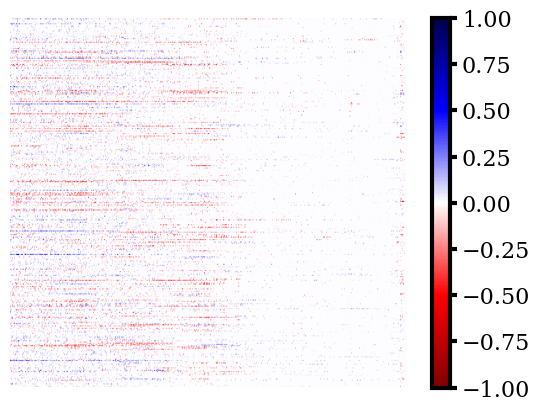

In [57]:

from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list(
    'custom',
    ['#c2452dff', 'white', '#2d82c2ff']
)

W = trace['iw'][-1]
#W = W[::4,::8]
#W = trace['rw'][-1]
lim = abs(W).max()
lim = 1
plt.imshow(W, aspect='auto', cmap='seismic_r', vmin=-lim, vmax=lim)
plt.colorbar()
plt.axis('off')
plt.savefig('img/spweights_iw_full.svg')

plt.figure()

#W = trace['iw'][-1]
W = trace['rw'][-1]
#W = W[::4,::4]
lim = abs(W).max()
lim = 1
plt.imshow(W, aspect='auto', cmap='seismic_r', vmin=-lim, vmax=lim)
plt.colorbar()
plt.axis('off')
plt.savefig('img/spweights_rw_full.svg')

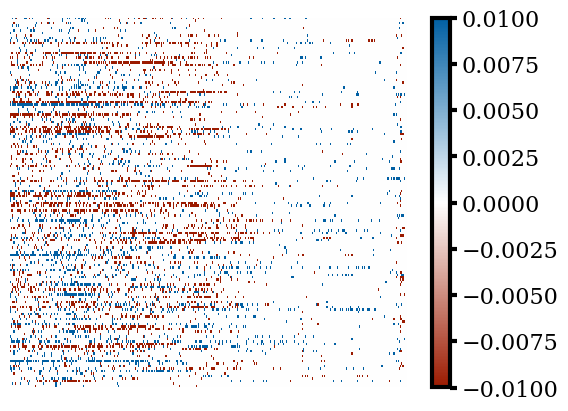

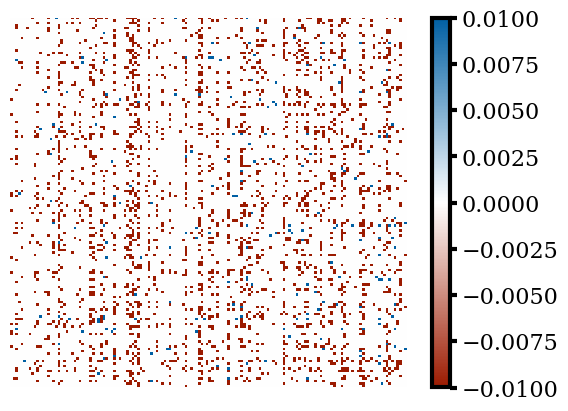

In [79]:
from matplotlib.colors import LinearSegmentedColormap


bottom = '#9b1a00ff'   # stronger red
mid    = 'white'
top    = '#005fa3ff'   # stronger blue

cmap = LinearSegmentedColormap.from_list(
    'custom_sat',
    [bottom, mid, top]
)

lim = max(abs(trace['iw'][::2]).max(), abs(trace['rw'][::2]).max())
lim = 0.01

W = trace['iw'][-1]
W = W[::2,::2]
plt.imshow(W, aspect='auto', cmap=cmap, vmin=-lim, vmax=lim, interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.savefig('img/spweights_zoom.svg')

plt.figure()

#W = trace['iw'][-1]
W = trace['rw'][-1]
W = W[::2,::2]
plt.imshow(W, aspect='auto', cmap=cmap, vmin=-lim, vmax=lim, interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.savefig('img/spweights_zoomrw.svg')

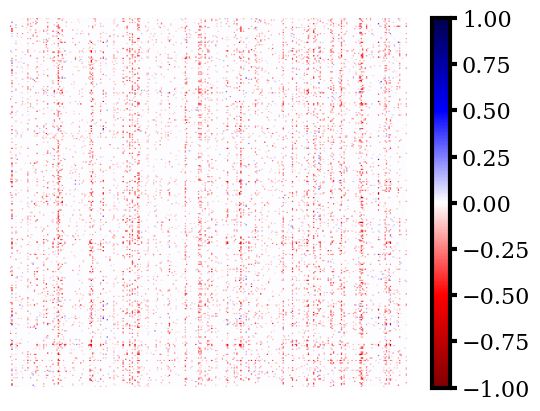

In [ ]:
iw = trace['iw'][-1].flatten()
rw = trace['rw'][-1].flatten()
idel = spatial_to_delay(trace['rpos'][-1], trace['ipos'][-1])
rdel = spatial_to_delay(trace['rpos'][-1])

/tmp/ipykernel_217663/2993396173.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


''

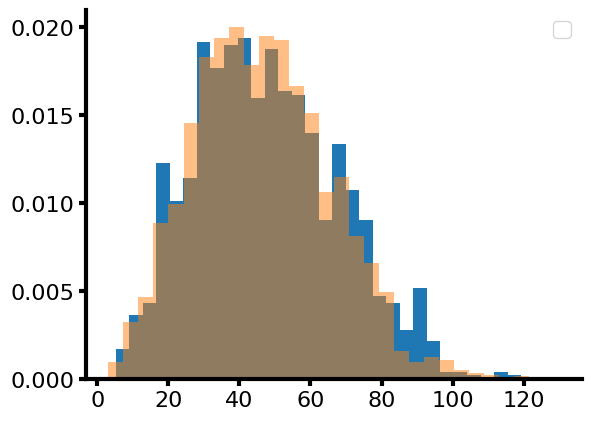

In [136]:
rm = (trace['rw'][-1] != 0)

def rdf(dist, r_max=None, dr=0.01, density=1.0):
    r_max = r_max or dist.max()
    bins = np.arange(0, r_max + dr, dr)
    hist, edges = np.histogram(dist, bins=bins)
    r = 0.5 * (edges[1:] + edges[:-1])
    shell_vol = 4 * np.pi * r**2 * dr
    g_r = hist / (shell_vol * density)
    return r, g_r
    
thres = 50

lbl = rm.sum(0) > thres
lbl1 = np.where(lbl)[0]
lbl0 = np.where(~lbl)[0]

hi = (rdel.reshape(300,300)*rm)[lbl1[:,None], lbl1[None,:]]
hi = hi[~np.eye(hi.shape[0], dtype=bool)]
hi = hi[hi != 0]

lo = (rdel.reshape(300,300)*rm)[lbl0[:,None], lbl0[None,:]]
lo = lo[~np.eye(lo.shape[0], dtype=bool)]
lo = lo[lo != 0]

#x, y = rdf(hi, dr=5, density=0.8)
#plt.plot(x, y/y.max(), label='hi')
plt.hist(hi, bins=30,density=True)
#x, y = rdf(lo, dr=5, density=0.8)
#plt.plot(x, y/y.max(), label='lo')
plt.hist(lo, bins=30, alpha=0.5,density=True)
plt.legend()

;

/tmp/ipykernel_10139/3755571902.py:2: RuntimeWarning: invalid value encountered in divide
  p = (W > 0).sum(0) / (W != 0).sum(0)


(0.0, 1.0)

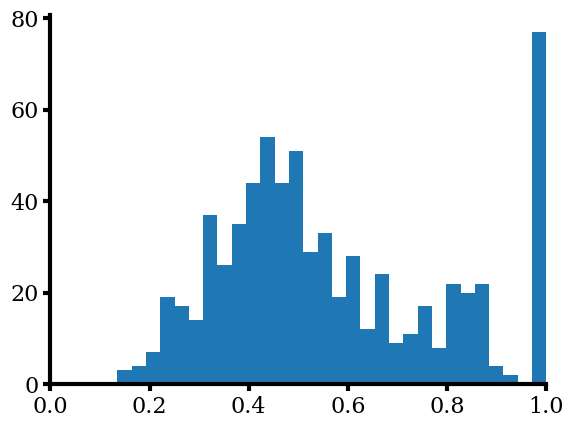

In [46]:
W = trace['iw'][-1]
p = (W > 0).sum(0) / (W != 0).sum(0)
plt.hist(p, bins=30)
plt.xlim(0, 1)


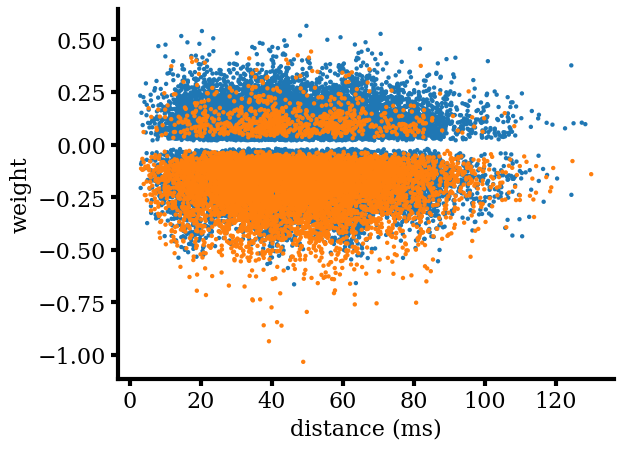

In [33]:
im = (iw != 0)
rm = (rw != 0)
plt.scatter(idel[im], iw[im], s=10, label='Input', edgecolor='none')
plt.scatter(rdel[rm], rw[rm], s=10, label='Recurrent', edgecolor='none')

plt.xlabel('distance (ms)')
plt.ylabel('weight')

#plt.legend()
plt.savefig('img/sparse0.1.svg')
plt.savefig('img/sparse0.1.png')

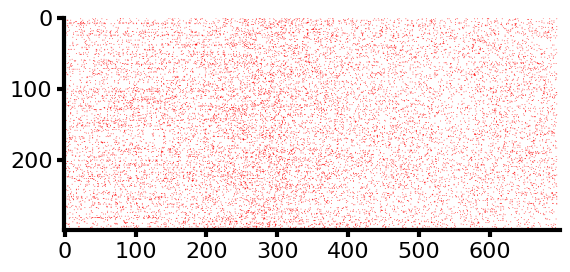

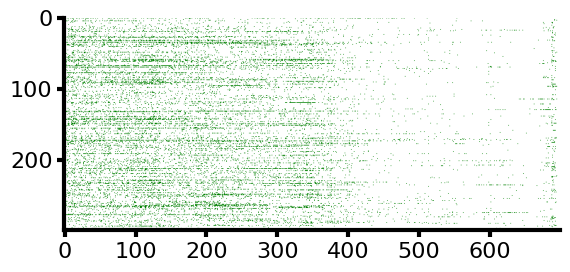

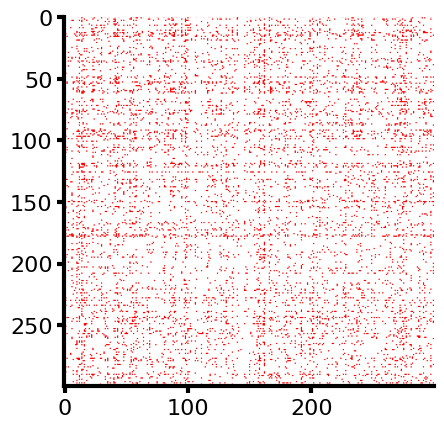

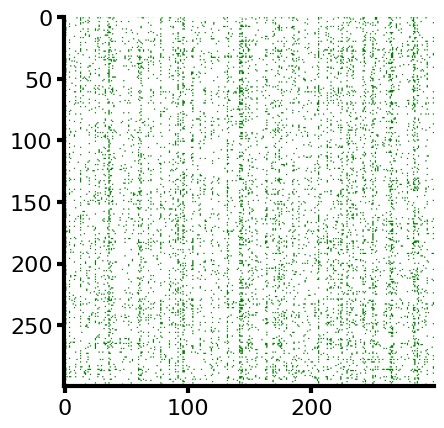

In [365]:
from matplotlib.colors import LinearSegmentedColormap

iw = trace['iw'] != 0
rw = trace['rw'] != 0


#new = iw[-1] > iw[0]
#rem = iw[-1] < iw[0]


bottom = '#9b1a00ff'   # stronger red
mid    = 'white'
top    = '#005fa3ff'   # stronger blue

bottom = 'red'   # stronger red
mid    = 'white'
top    = 'green'   # stronger blue

added = LinearSegmentedColormap.from_list(
    'custom_sat',
    [mid, top]
)

removed = LinearSegmentedColormap.from_list(
    'custom_sat',
    [mid, bottom]
)

x = iw[0].astype(float) - iw[-1].astype(float)
plt.imshow(x>0, cmap=removed)
plt.savefig('img/remi.svg')
plt.figure()
plt.imshow(x<0, cmap=added)
plt.savefig('img/addi.svg')
plt.figure()

x = rw[0].astype(float) - rw[-1].astype(float)
plt.imshow(x>0, cmap=removed)
plt.savefig('img/remr.svg')
plt.figure()
plt.imshow(x<0, cmap=added)
plt.savefig('img/addr.svg')

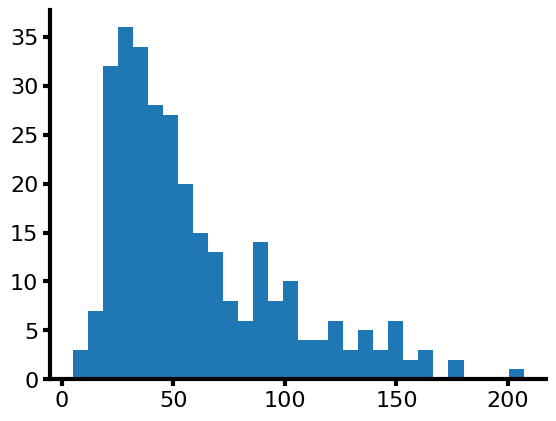

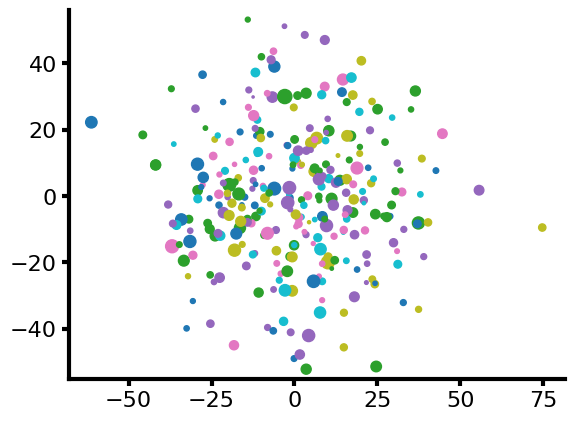

In [358]:
import networkx as nx


# !pip install python-louvain
import community as community_louvain 

G = nx.from_numpy_array(rw[-1], create_using=nx.DiGraph)
G_undir = G.to_undirected()

partition = community_louvain.best_partition(G_undir)


degrees = np.array([d for n, d in G.degree()])

plt.hist(degrees, bins=30);

plt.savefig('img/sparsedegrees.svg')

plt.figure()

x, y, z = trace['rpos'][-1].T

plt.scatter(x, y, s=degrees/2, c=partition.values(), cmap='tab10')
plt.axis('equal')


plt.savefig('img/sparseclust.svg')


''

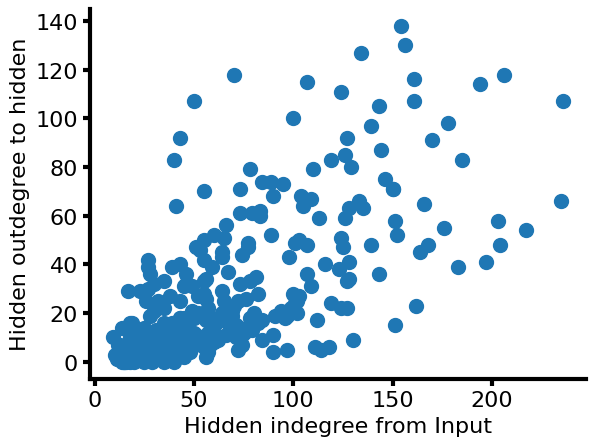

In [397]:
x = (trace['iw'][-1] != 0).sum(1)
y = (trace['rw'][-1] != 0).sum(0)

plt.xlabel('Hidden indegree from Input')
plt.ylabel('Hidden outdegree to hidden')

plt.scatter(x, y)

;

In [403]:
w = np.load(glob.glob(
    f'saved/*{ident}*/epoch_*29_read.npz'
   )[0])['w']
w.shape



(20, 300)

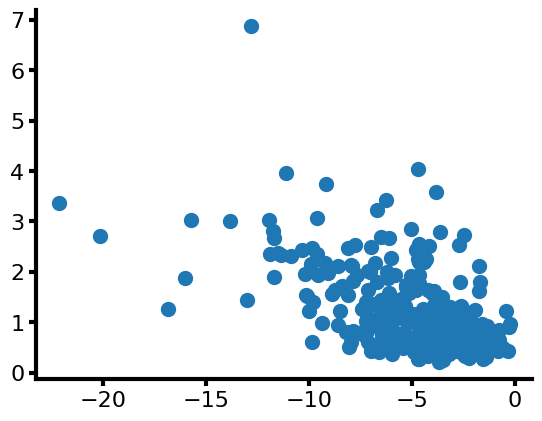

In [416]:
x = (trace['iw'][-1] != 0).sum(1)
y = (trace['rw'][-1] != 0).sum(0)

a = (trace['rw'][-1]).sum(1)
z = np.abs(w).sum(0)
plt.scatter(a, z)


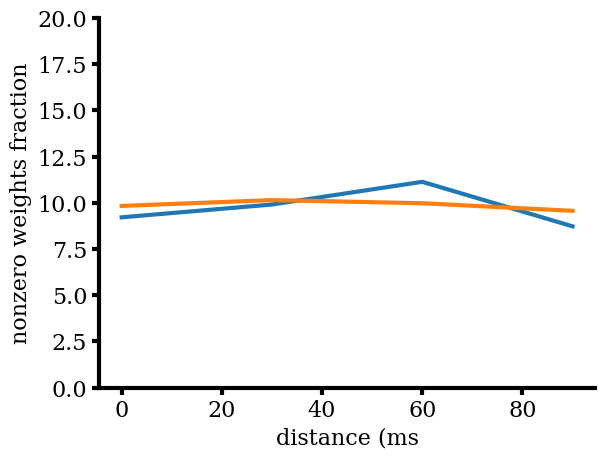

In [ ]:
# last_epochs = [
#     dict(np.load(x))
#     for x in 
#     sorted(x for x in glob.glob(
#         # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
#         # '/tmp/savd/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
#         f'saved/sparse*/epoch_00000029.npz'
#     ) if not 'read' in x)
# ]
# 



binsize = 30
o = []
for i in range(0, 120, binsize):
    m = (idel >= i) & (idel < i + binsize)
    mm = (rdel >= i) & (rdel < i + binsize)
    o.append(dict(
        i = i,
        ip = (iw[m] != 0).mean(),
        rp = (rw[mm] != 0).mean()
    ))

o = pd.DataFrame(o)
plt.plot(o.i, 100*o.ip)
plt.plot(o.i, 100*o.rp)

#plt.axhline(0.1)
plt.ylim([0, 20])

plt.xlabel('distance (ms')
plt.ylabel('nonzero weights fraction')

plt.savefig('img/sparse0.1_weights_fraction.svg')

[14.95411728  0.41777449 -6.04715443]
[19.14362472  2.95830318 -7.60846492]


([<matplotlib.axis.XTick at 0x72226ed68380>,
 [Text(1, 0, 'Dense I'),
  Text(2, 0, 'Sparse I'),
  Text(3, 0, 'Dense H'),
  Text(4, 0, 'Sparse H')])

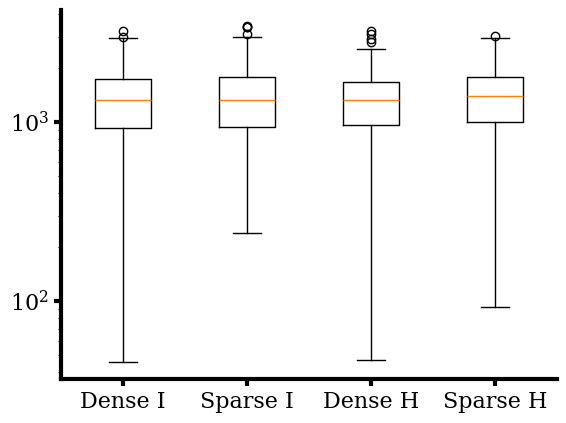

In [61]:
ipos = trace['ipos']
rpos = trace['rpos']

cipos = cmptrace['ipos']
crpos = cmptrace['rpos']


def dist(pos):
    diffs = np.diff(pos, axis=1)
    step = np.linalg.norm(diffs, axis=2)
    return step.sum(axis=0)
    

print(ipos[0][0])
print(ipos[-1][0])

#plt.hist(np.concatenate([ dist(crpos), dist(cipos) ]) , bins=30, density=True, alpha=0.5)
#plt.hist(np.concatenate([ dist(rpos), dist(ipos) ]), bins=30, density=True, alpha=0.5)

#plt.hist(np.concatenate([ dist(crpos) ]) , bins=30, density=True, alpha=0.5)
#plt.hist(np.concatenate([ dist(rpos) ]), bins=30, density=True, alpha=0.5)

plt.boxplot([
    dist(cipos),
    dist(ipos),
    dist(crpos),
    dist(rpos)
] )

;
plt.yscale('log')

plt.xticks([1,2,3,4],
           ['Dense I', 'Sparse I', 'Dense H', 'Sparse H'])

In [54]:
diffs = np.diff(rpos, axis=1)
diffs.shape
step = np.linalg.norm(diffs, axis=2)
print(step.shape)
step.sum(axis=1).shape

(30, 299)


(30,)

In [ ]:
epoch = -1

w = trace['iw'][-1]
wr = trace['rw'][-1]

x = trace['ipos'][:,:,0]
y = trace['ipos'][:,:,1]

xr = trace['rpos'][:,:,0]
yr = trace['rpos'][:,:,1]

print(x.shape)

print(1)
for ii, jj in zip(*np.where(w > 2)):
    plt.plot([ x[epoch, jj], xr[epoch, ii], ], [ y[epoch, jj], yr[epoch, ii] ], color='blue', lw=1, alpha=0.3)
print(1)
for ii, jj in zip(*np.where(w < -2)):
    plt.plot([ x[epoch, jj], xr[epoch, ii], ], [ y[epoch, jj], yr[epoch, ii] ], color='red', lw=1, alpha=0.3)
print(1)
for ii, jj in zip(*np.where(w > 0)):
    plt.plot([ x[epoch, jj], xr[epoch, ii], ], [ y[epoch, jj], yr[epoch, ii] ], color='blue', lw=1, alpha=0.1)
print(1)
for ii, jj in zip(*np.where(w < 0)):
    plt.plot([ x[epoch, jj], xr[epoch, ii], ], [ y[epoch, jj], yr[epoch, ii] ], color='red', lw=1, alpha=0.1)
print(1)
    
for ii, jj in zip(*np.where(wr > 2)):
    plt.plot([ xr[epoch, jj], xr[epoch, ii], ], [ yr[epoch, jj], yr[epoch, ii] ], color='blue', lw=1, alpha=0.3)
print(1)
for ii, jj in zip(*np.where(wr < -2)):
    plt.plot([ xr[epoch, jj], xr[epoch, ii], ], [ yr[epoch, jj], yr[epoch, ii] ], color='red', lw=1, alpha=0.3)
print(1)
for ii, jj in zip(*np.where(wr > 0)):
    plt.plot([ xr[epoch, jj], xr[epoch, ii], ], [ yr[epoch, jj], yr[epoch, ii] ], color='blue', lw=1, alpha=0.1)
print(1)
for ii, jj in zip(*np.where(wr < 0)):
    plt.plot([ xr[epoch, jj], xr[epoch, ii], ], [ yr[epoch, jj], yr[epoch, ii] ], color='red', lw=1, alpha=0.1)
print(1)
    
plt.scatter(x[epoch], y[epoch], c=np.arange(700), s=5, cmap='plasma', zorder=10)
print(1)
plt.scatter(xr[epoch], yr[epoch], color='black', s=5, zorder=10)
print(1)

plt.axis('equal')

plt.tight_layout()
#plt.savefig('img/sparsom.svg')
#plt.savefig('img/sparsom.png')

# 3d plot shd

In [92]:
ident = '20251113_d3_h30_lr0.001_llNone_dt0.5_d15a0edd-1cf0-431a-bcb0-e349b109368d'
trace = [
    dict(np.load(x))
    for x in 
    sorted(x for x in glob.glob(
        # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/savd/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
        f'saved/{ident}/epoch_*.npz'
    ) if not 'read' in x)
]

columns = trace[0].keys()

trace = {
    k: np.array([x[k] for x in trace]) for k in columns
}

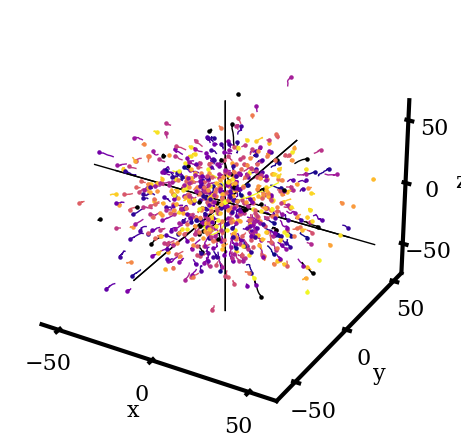

In [124]:

from mpl_toolkits.mplot3d import Axes3D  # sigh, still required

# trace['ipos'].shape # time, neuron, (x,y,z)
# trace['rpos'].shape # time, neuron, (x,y,z)

ipos = trace['ipos']
rpos = trace['rpos']

T, N, _3 = ipos.shape
cmap = plt.get_cmap('plasma')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', computed_zorder=True)

ax.xaxis.set_pane_color((1,1,1,0))
ax.yaxis.set_pane_color((1,1,1,0))
ax.zaxis.set_pane_color((1,1,1,0))



all_points = ipos.reshape(-1,3)
xlim = (all_points[:,0].min(), all_points[:,0].max())
ylim = (all_points[:,1].min(), all_points[:,1].max())
zlim = (all_points[:,2].min(), all_points[:,2].max())


def draw_plane(func, u_range, v_range, color='gray', alpha=0.5, steps=30):
    u_vals = np.linspace(u_range[0], u_range[1], steps)
    v_vals = np.linspace(v_range[0], v_range[1], steps)
    for i in range(steps-1):
        for j in range(steps-1):
            u0, u1 = u_vals[i], u_vals[i+1]
            v0, v1 = v_vals[j], v_vals[j+1]
            uu, vv = np.meshgrid([u0, u1], [v0, v1])
            xx, yy, zz = func(uu, vv)
            ax.plot_surface(xx, yy, zz, color=color, alpha=alpha)

# x=0 plane
#draw_plane(lambda y,z: (np.zeros_like(y), y, z), ylim, zlim)

# y=0 plane
#draw_plane(lambda x,z: (x, np.zeros_like(x), z), xlim, zlim)

# z=0 plane
#draw_plane(lambda x,y: (x, y, np.zeros_like(x)), xlim, ylim)

for i in range(N):
    p = ipos[:, i]
    c = cmap(i / (N - 1)) if N > 1 else cmap(0)
    ax.plot(p[:,0], p[:,1], p[:,2], color=c, linewidth=1)
    ax.scatter(p[-1,0], p[-1,1], p[-1,2], color=c, s=5)
    
T, N, _3 = rpos.shape
for i in range(N):
    p = rpos[:, i]
    ax.plot(p[:,0], p[:,1], p[:,2], color='black', linewidth=1)
    ax.scatter(p[-1,0], p[-1,1], p[-1,2], color='black', s=5)


ax.grid(False)


# draw planes at x=0, y=0, z=0

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

a = 1.2

ax.plot([0,0], [a*ylim[0], a*ylim[1]], [0,0], color='k', linewidth=1)  # along y
ax.plot([0,0], [0,0], [a*zlim[0], a*zlim[1]], color='k', linewidth=1)  # along z

# y=0 line along x and z
ax.plot([a*xlim[0], a*xlim[1]], [0,0], [0,0], color='k', linewidth=1)  # along x
ax.plot([0,0], [0,0], [a*zlim[0], a*zlim[1]], color='k', linewidth=1)  # along z

# z=0 line along x and y
ax.plot([xlim[0], xlim[1]], [0,0], [0,0], color='k', linewidth=1)  # along x
ax.plot([0,0], [a*ylim[0], a*ylim[1]], [0,0], color='k', linewidth=1)  # along y

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.set_xticks([-50, 0, 50])
ax.set_yticks([-50, 0, 50])
ax.set_zticks([-50, 0, 50])

fig.savefig('img/3dshd.svg')

plt.tight_layout()
plt.show()

# New results

In [68]:
!ls saved | grep 202512

20251202_d0_h300_lr0.001_llNone_dt0.5_0ac9f30e-9eae-44a9-80bf-d5eae0b2e0a4
20251202_d2_h300_lr0.001_llNone_dt0.5_8d6a325b-007c-4153-bee9-0ca59a1ea451
20251202_d3_h300_lr0.001_llNone_dt0.5_60a91ecd-ba81-4ec7-9d11-a2314ed8c9c7
20251202_d3_h30_lr0.01_llNone_dt0.05_36a83d6c-59ad-4b80-9ad8-9e643368b771
20251202_dinf_h100_lr0.001_llNone_dt0.05_b3620b03-0519-4260-8a3c-32e55d54a5f0
20251202_dinf_h300_lr0.001_llNone_dt0.5_8b99594b-1be6-45d5-ac71-b2ce88b6edbc
20251202_dinf_h300_lr0.001_llNone_dt0.5_bab14453-6133-4e0b-a1f9-cd1ff9fffdb3
adex_20251202_d3_h100_lr0.001_llNone_dt0.5_52034ef7-696a-4e08-a617-2c98f4624e02
adex_20251202_d3_h100_lr0.001_llNone_dt0.5_a84a445f-9a93-49e2-a55c-56e1f4837198
adex_20251202_d3_h10_lr0.001_llNone_dt0.5_126ec515-f6d4-4d92-9308-101b3706f430
adex_20251202_d3_h10_lr0.001_llNone_dt0.5_98b06d44-c765-4569-9261-084e9b92fbe8
adex_20251202_d3_h300_lr0.001_llNone_dt0.5_2a3ba080-f76f-4ac9-ad59-eb61c45bd72a
adex_20251202_d3_h300_lr0.001_llNone_dt0.5_bf90c64e-1ade-4e32-b228-cce8

## Mapping it 

In [4]:
ident = '20251202_dinf_h300_lr0.001_llNone_dt0.5_8b99594b-1be6-45d5-ac71-b2ce88b6edbc'
trace = [
    dict(np.load(x))
    for x in 
    sorted(x for x in glob.glob(
        # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/savd/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
        f'saved/{ident}/epoch_*.npz'
    ) if not 'read' in x)
]

columns = trace[0].keys()

trace = {
    k: np.array([x[k] for x in trace]) for k in columns
}

In [5]:
idel = trace['idelay'][-1].reshape(300, 700)
rdel = trace['rdelay'][-1].reshape(300, 300)

rdel = rdel * (1-np.eye(len(rdel)))



In [24]:
        
import numpy as np
import optax

from scipy.optimize import minimize
from scipy.optimize import least_squares

def classical_mds(rdel, ndim):
    N = rdel.shape[0]
    rdel = rdel.astype(np.float64)  # make sure it's float
    # double centering
    H = np.eye(N) - np.ones((N, N), dtype=np.float64) / N
    B = -0.5 * H @ (rdel**2) @ H
    # eigendecomposition
    eigvals, eigvecs = np.linalg.eigh(B)
    idx = np.argsort(eigvals)[::-1][:ndim]
    L = np.diag(np.sqrt(np.maximum(eigvals[idx], 0)))
    V = eigvecs[:, idx]
    return V @ L

def pairwise_dist_upper(x, eps=1e-12):
    diff = x[:, None, :] - x[None, :, :]
    D = jnp.sqrt(jnp.sum(diff**2, axis=-1) + eps)
    return D

def loss_fn(x, rdel):
    D = pairwise_dist(x)
    return jnp.mean((D - rdel)**2)
    
@jax.jit
def step(x, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(x, rdel)
    updates, opt_state = opt.update(grads, opt_state, x)
    x = optax.apply_updates(x, updates)
    return x, opt_state, loss    
lr = 0.01

ndims = [1,2,3,4,5,6,7,8,9,10, 20, 50, 100, 150, 200, 250, 300]
#ndims = [20, 50, 100]
rs = []
for ndim in tqdm.tqdm(ndims):
    print(ndim)
    opt = optax.adam(lr)
    x = classical_mds(rdel, ndim)
    opt_state = opt.init(x)
    N = rdel.shape[0]
    for i in range(50000):
        x, opt_state, loss = step(x, opt_state)
        if i % 500 == 0:
            print(f"iter {i}, loss {loss:.6f}")
    rs.append(x)
    

  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

1
iter 0, loss 17.982426
iter 500, loss 8.702343
iter 1000, loss 8.412134
iter 1500, loss 8.403326
iter 2000, loss 8.403118
iter 2500, loss 8.403118
iter 3000, loss 8.403118
iter 3500, loss 8.403118
iter 4000, loss 8.403118
iter 4500, loss 8.403118
iter 5000, loss 8.403118
iter 5500, loss 8.403118
iter 6000, loss 8.403118
iter 6500, loss 8.403118
iter 7000, loss 8.403118
iter 7500, loss 8.403118
iter 8000, loss 8.403118
iter 8500, loss 8.403118
iter 9000, loss 8.403118
iter 9500, loss 8.403118
iter 10000, loss 8.403118
iter 10500, loss 8.403118
iter 11000, loss 8.403118
iter 11500, loss 8.403118
iter 12000, loss 8.403118
iter 12500, loss 8.403118
iter 13000, loss 8.400970
iter 13500, loss 8.400970
iter 14000, loss 8.400970
iter 14500, loss 8.400970
iter 15000, loss 8.400970
iter 15500, loss 8.400970
iter 16000, loss 8.400970
iter 16500, loss 8.400970
iter 17000, loss 8.400970
iter 17500, loss 8.400970
iter 18000, loss 8.400970
iter 18500, loss 8.400970
iter 19000, loss 8.400970
iter 19

  6%|████▉                                                                              | 1/17 [00:03<00:50,  3.18s/it]

iter 48500, loss 8.400970
iter 49000, loss 8.400970
iter 49500, loss 8.400970
2
iter 0, loss 12.858679
iter 500, loss 5.234071
iter 1000, loss 5.112914
iter 1500, loss 5.086143
iter 2000, loss 5.067565
iter 2500, loss 5.059477
iter 3000, loss 5.052529
iter 3500, loss 5.046308
iter 4000, loss 5.041041
iter 4500, loss 5.036839
iter 5000, loss 5.032561
iter 5500, loss 5.031537
iter 6000, loss 5.031479
iter 6500, loss 5.031384
iter 7000, loss 5.031370
iter 7500, loss 5.030629
iter 8000, loss 5.030069
iter 8500, loss 5.030051
iter 9000, loss 5.030000
iter 9500, loss 5.029990
iter 10000, loss 5.029905
iter 10500, loss 5.029897
iter 11000, loss 5.029897
iter 11500, loss 5.029897
iter 12000, loss 5.029897
iter 12500, loss 5.029897
iter 13000, loss 5.029897
iter 13500, loss 5.029897
iter 14000, loss 5.029897
iter 14500, loss 5.029897
iter 15000, loss 5.029897
iter 15500, loss 5.029898
iter 16000, loss 5.029897
iter 16500, loss 5.029897
iter 17000, loss 5.029897
iter 17500, loss 5.029897
iter 18

 12%|█████████▊                                                                         | 2/17 [00:06<00:49,  3.28s/it]

iter 48500, loss 5.029897
iter 49000, loss 5.029897
iter 49500, loss 5.029897
3
iter 0, loss 10.111667
iter 500, loss 4.131467
iter 1000, loss 4.038773
iter 1500, loss 4.004951
iter 2000, loss 3.986652
iter 2500, loss 3.972969
iter 3000, loss 3.964590
iter 3500, loss 3.957452
iter 4000, loss 3.951792
iter 4500, loss 3.946904
iter 5000, loss 3.943976
iter 5500, loss 3.941462
iter 6000, loss 3.939762
iter 6500, loss 3.937738
iter 7000, loss 3.935885
iter 7500, loss 3.935595
iter 8000, loss 3.935388
iter 8500, loss 3.935254
iter 9000, loss 3.934750
iter 9500, loss 3.934407
iter 10000, loss 3.934401
iter 10500, loss 3.934400
iter 11000, loss 3.934400
iter 11500, loss 3.934400
iter 12000, loss 3.934400
iter 12500, loss 3.934400
iter 13000, loss 3.934400
iter 13500, loss 3.934400
iter 14000, loss 3.934401
iter 14500, loss 3.934400
iter 15000, loss 3.934400
iter 15500, loss 3.934400
iter 16000, loss 3.934400
iter 16500, loss 3.934400
iter 17000, loss 3.934400
iter 17500, loss 3.934400
iter 18

 18%|██████████████▋                                                                    | 3/17 [00:09<00:46,  3.30s/it]

iter 49000, loss 3.934375
iter 49500, loss 3.934375
4
iter 0, loss 8.398209
iter 500, loss 3.586217
iter 1000, loss 3.523617
iter 1500, loss 3.499815
iter 2000, loss 3.485251
iter 2500, loss 3.476305
iter 3000, loss 3.470525
iter 3500, loss 3.465368
iter 4000, loss 3.462250
iter 4500, loss 3.459593
iter 5000, loss 3.456020
iter 5500, loss 3.452267
iter 6000, loss 3.450269
iter 6500, loss 3.449379
iter 7000, loss 3.448546
iter 7500, loss 3.448148
iter 8000, loss 3.447946
iter 8500, loss 3.447883
iter 9000, loss 3.447830
iter 9500, loss 3.447778
iter 10000, loss 3.447770
iter 10500, loss 3.447770
iter 11000, loss 3.447770
iter 11500, loss 3.447770
iter 12000, loss 3.447768
iter 12500, loss 3.447768
iter 13000, loss 3.447768
iter 13500, loss 3.447768
iter 14000, loss 3.447768
iter 14500, loss 3.447768
iter 15000, loss 3.447767
iter 15500, loss 3.447767
iter 16000, loss 3.447767
iter 16500, loss 3.447767
iter 17000, loss 3.447767
iter 17500, loss 3.447769
iter 18000, loss 3.447767
iter 185

 24%|███████████████████▌                                                               | 4/17 [00:13<00:42,  3.26s/it]

iter 48000, loss 3.447765
iter 48500, loss 3.447766
iter 49000, loss 3.447766
iter 49500, loss 3.447765
5
iter 0, loss 6.989835
iter 500, loss 3.260224
iter 1000, loss 3.212497
iter 1500, loss 3.195325
iter 2000, loss 3.186497
iter 2500, loss 3.180795
iter 3000, loss 3.177813
iter 3500, loss 3.176040
iter 4000, loss 3.175010
iter 4500, loss 3.174528
iter 5000, loss 3.174252
iter 5500, loss 3.173933
iter 6000, loss 3.173702
iter 6500, loss 3.173481
iter 7000, loss 3.173250
iter 7500, loss 3.172943
iter 8000, loss 3.172137
iter 8500, loss 3.171096
iter 9000, loss 3.170013
iter 9500, loss 3.169190
iter 10000, loss 3.168969
iter 10500, loss 3.168804
iter 11000, loss 3.168802
iter 11500, loss 3.168802
iter 12000, loss 3.168790
iter 12500, loss 3.168792
iter 13000, loss 3.168789
iter 13500, loss 3.168790
iter 14000, loss 3.168789
iter 14500, loss 3.168792
iter 15000, loss 3.168789
iter 15500, loss 3.168789
iter 16000, loss 3.168790
iter 16500, loss 3.168789
iter 17000, loss 3.168789
iter 175

 29%|████████████████████████▍                                                          | 5/17 [00:16<00:39,  3.30s/it]

iter 49000, loss 3.168789
iter 49500, loss 3.168789
6
iter 0, loss 6.142726
iter 500, loss 3.075384
iter 1000, loss 3.035333
iter 1500, loss 3.020208
iter 2000, loss 3.012159
iter 2500, loss 3.007681
iter 3000, loss 3.005242
iter 3500, loss 3.003758
iter 4000, loss 3.002639
iter 4500, loss 3.001531
iter 5000, loss 3.000885
iter 5500, loss 3.000252
iter 6000, loss 2.999675
iter 6500, loss 2.999244
iter 7000, loss 2.999006
iter 7500, loss 2.998840
iter 8000, loss 2.998824
iter 8500, loss 2.998806
iter 9000, loss 2.998804
iter 9500, loss 2.998804
iter 10000, loss 2.998804
iter 10500, loss 2.998804
iter 11000, loss 2.998802
iter 11500, loss 2.998798
iter 12000, loss 2.998797
iter 12500, loss 2.998797
iter 13000, loss 2.998797
iter 13500, loss 2.998797
iter 14000, loss 2.998798
iter 14500, loss 2.998797
iter 15000, loss 2.998797
iter 15500, loss 2.998797
iter 16000, loss 2.998797
iter 16500, loss 2.998797
iter 17000, loss 2.998797
iter 17500, loss 2.998796
iter 18000, loss 2.998797
iter 185

 35%|█████████████████████████████▎                                                     | 6/17 [00:19<00:35,  3.26s/it]

iter 49500, loss 2.998735
7
iter 0, loss 5.481286
iter 500, loss 2.942858
iter 1000, loss 2.909300
iter 1500, loss 2.898269
iter 2000, loss 2.892392
iter 2500, loss 2.889451
iter 3000, loss 2.887877
iter 3500, loss 2.886851
iter 4000, loss 2.886050
iter 4500, loss 2.885445
iter 5000, loss 2.885106
iter 5500, loss 2.884975
iter 6000, loss 2.884775
iter 6500, loss 2.884609
iter 7000, loss 2.884461
iter 7500, loss 2.884334
iter 8000, loss 2.884205
iter 8500, loss 2.884145
iter 9000, loss 2.884102
iter 9500, loss 2.884055
iter 10000, loss 2.884054
iter 10500, loss 2.884048
iter 11000, loss 2.884037
iter 11500, loss 2.884036
iter 12000, loss 2.884037
iter 12500, loss 2.884043
iter 13000, loss 2.884036
iter 13500, loss 2.884036
iter 14000, loss 2.884018
iter 14500, loss 2.884018
iter 15000, loss 2.884015
iter 15500, loss 2.884015
iter 16000, loss 2.884015
iter 16500, loss 2.884016
iter 17000, loss 2.884015
iter 17500, loss 2.884015
iter 18000, loss 2.884015
iter 18500, loss 2.884021
iter 190

 41%|██████████████████████████████████▏                                                | 7/17 [00:23<00:33,  3.34s/it]

iter 49000, loss 2.884015
iter 49500, loss 2.884015
8
iter 0, loss 5.094867
iter 500, loss 2.852613
iter 1000, loss 2.824856
iter 1500, loss 2.814347
iter 2000, loss 2.808770
iter 2500, loss 2.805927
iter 3000, loss 2.804319
iter 3500, loss 2.803467
iter 4000, loss 2.802994
iter 4500, loss 2.802669
iter 5000, loss 2.802431
iter 5500, loss 2.802213
iter 6000, loss 2.801991
iter 6500, loss 2.801711
iter 7000, loss 2.801528
iter 7500, loss 2.801467
iter 8000, loss 2.801371
iter 8500, loss 2.801349
iter 9000, loss 2.801327
iter 9500, loss 2.801315
iter 10000, loss 2.801312
iter 10500, loss 2.801311
iter 11000, loss 2.801311
iter 11500, loss 2.801309
iter 12000, loss 2.801307
iter 12500, loss 2.801306
iter 13000, loss 2.801306
iter 13500, loss 2.801306
iter 14000, loss 2.801306
iter 14500, loss 2.801306
iter 15000, loss 2.801306
iter 15500, loss 2.801307
iter 16000, loss 2.801305
iter 16500, loss 2.801304
iter 17000, loss 2.801304
iter 17500, loss 2.801303
iter 18000, loss 2.801298
iter 185

 47%|███████████████████████████████████████                                            | 8/17 [00:26<00:29,  3.30s/it]

9
iter 0, loss 4.851951
iter 500, loss 2.783740
iter 1000, loss 2.760557
iter 1500, loss 2.751395
iter 2000, loss 2.747194
iter 2500, loss 2.745002
iter 3000, loss 2.743857
iter 3500, loss 2.743150
iter 4000, loss 2.742726
iter 4500, loss 2.742437
iter 5000, loss 2.742215
iter 5500, loss 2.742038
iter 6000, loss 2.741836
iter 6500, loss 2.741607
iter 7000, loss 2.741315
iter 7500, loss 2.740886
iter 8000, loss 2.740659
iter 8500, loss 2.740649
iter 9000, loss 2.740643
iter 9500, loss 2.740638
iter 10000, loss 2.740638
iter 10500, loss 2.740640
iter 11000, loss 2.740637
iter 11500, loss 2.740636
iter 12000, loss 2.740641
iter 12500, loss 2.740636
iter 13000, loss 2.740646
iter 13500, loss 2.740632
iter 14000, loss 2.740632
iter 14500, loss 2.740628
iter 15000, loss 2.740639
iter 15500, loss 2.740625
iter 16000, loss 2.740623
iter 16500, loss 2.740620
iter 17000, loss 2.740620
iter 17500, loss 2.740620
iter 18000, loss 2.740619
iter 18500, loss 2.740619
iter 19000, loss 2.740621
iter 195

 53%|███████████████████████████████████████████▉                                       | 9/17 [00:29<00:26,  3.33s/it]

iter 49000, loss 2.740616
iter 49500, loss 2.740616
10
iter 0, loss 4.688746
iter 500, loss 2.729890
iter 1000, loss 2.710499
iter 1500, loss 2.703637
iter 2000, loss 2.701071
iter 2500, loss 2.699653
iter 3000, loss 2.698677
iter 3500, loss 2.698022
iter 4000, loss 2.697551
iter 4500, loss 2.697133
iter 5000, loss 2.696812
iter 5500, loss 2.696615
iter 6000, loss 2.696515
iter 6500, loss 2.696439
iter 7000, loss 2.696388
iter 7500, loss 2.696325
iter 8000, loss 2.696240
iter 8500, loss 2.696198
iter 9000, loss 2.696164
iter 9500, loss 2.696156
iter 10000, loss 2.696151
iter 10500, loss 2.696149
iter 11000, loss 2.696147
iter 11500, loss 2.696147
iter 12000, loss 2.696147
iter 12500, loss 2.696145
iter 13000, loss 2.696147
iter 13500, loss 2.696145
iter 14000, loss 2.696145
iter 14500, loss 2.696145
iter 15000, loss 2.696145
iter 15500, loss 2.696145
iter 16000, loss 2.696145
iter 16500, loss 2.696145
iter 17000, loss 2.696145
iter 17500, loss 2.696144
iter 18000, loss 2.696145
iter 18

 59%|████████████████████████████████████████████████▏                                 | 10/17 [00:33<00:23,  3.35s/it]

iter 49000, loss 2.696144
iter 49500, loss 2.696144
20
iter 0, loss 6.583760
iter 500, loss 2.562187
iter 1000, loss 2.546204
iter 1500, loss 2.540095
iter 2000, loss 2.537100
iter 2500, loss 2.535384
iter 3000, loss 2.534334
iter 3500, loss 2.533570
iter 4000, loss 2.533080
iter 4500, loss 2.532674
iter 5000, loss 2.532095
iter 5500, loss 2.531449
iter 6000, loss 2.530962
iter 6500, loss 2.530544
iter 7000, loss 2.530073
iter 7500, loss 2.529775
iter 8000, loss 2.529610
iter 8500, loss 2.529401
iter 9000, loss 2.529338
iter 9500, loss 2.529294
iter 10000, loss 2.529275
iter 10500, loss 2.529266
iter 11000, loss 2.529238
iter 11500, loss 2.529224
iter 12000, loss 2.529219
iter 12500, loss 2.529200
iter 13000, loss 2.529203
iter 13500, loss 2.529187
iter 14000, loss 2.529183
iter 14500, loss 2.529181
iter 15000, loss 2.529181
iter 15500, loss 2.529180
iter 16000, loss 2.529178
iter 16500, loss 2.529180
iter 17000, loss 2.529176
iter 17500, loss 2.529175
iter 18000, loss 2.529175
iter 18

 65%|█████████████████████████████████████████████████████                             | 11/17 [00:37<00:22,  3.70s/it]

50
iter 0, loss 21.307866
iter 500, loss 2.547895
iter 1000, loss 2.523766
iter 1500, loss 2.513756
iter 2000, loss 2.508563
iter 2500, loss 2.505451
iter 3000, loss 2.503211
iter 3500, loss 2.501412
iter 4000, loss 2.499977
iter 4500, loss 2.498831
iter 5000, loss 2.497950
iter 5500, loss 2.497145
iter 6000, loss 2.496468
iter 6500, loss 2.495954
iter 7000, loss 2.495514
iter 7500, loss 2.495198
iter 8000, loss 2.494951
iter 8500, loss 2.494762
iter 9000, loss 2.494614
iter 9500, loss 2.494477
iter 10000, loss 2.494374
iter 10500, loss 2.494266
iter 11000, loss 2.494145
iter 11500, loss 2.494056
iter 12000, loss 2.494007
iter 12500, loss 2.493985
iter 13000, loss 2.493969
iter 13500, loss 2.493955
iter 14000, loss 2.493940
iter 14500, loss 2.493917
iter 15000, loss 2.493909
iter 15500, loss 2.493893
iter 16000, loss 2.493854
iter 16500, loss 2.493844
iter 17000, loss 2.493825
iter 17500, loss 2.493813
iter 18000, loss 2.493806
iter 18500, loss 2.493807
iter 19000, loss 2.493800
iter 1

 71%|█████████████████████████████████████████████████████████▉                        | 12/17 [00:49<00:31,  6.22s/it]

100
iter 0, loss 41.146775
iter 500, loss 2.577093
iter 1000, loss 2.549113
iter 1500, loss 2.537219
iter 2000, loss 2.530739
iter 2500, loss 2.526635
iter 3000, loss 2.523800
iter 3500, loss 2.521632
iter 4000, loss 2.519854
iter 4500, loss 2.518442
iter 5000, loss 2.517239
iter 5500, loss 2.516170
iter 6000, loss 2.515368
iter 6500, loss 2.514789
iter 7000, loss 2.514302
iter 7500, loss 2.513848
iter 8000, loss 2.513496
iter 8500, loss 2.513199
iter 9000, loss 2.512970
iter 9500, loss 2.512784
iter 10000, loss 2.512668
iter 10500, loss 2.512534
iter 11000, loss 2.512400
iter 11500, loss 2.512318
iter 12000, loss 2.512234
iter 12500, loss 2.512187
iter 13000, loss 2.512088
iter 13500, loss 2.512065
iter 14000, loss 2.512053
iter 14500, loss 2.511962
iter 15000, loss 2.511881
iter 15500, loss 2.511825
iter 16000, loss 2.511781
iter 16500, loss 2.511720
iter 17000, loss 2.511691
iter 17500, loss 2.511662
iter 18000, loss 2.511627
iter 18500, loss 2.511628
iter 19000, loss 2.511595
iter 

 76%|██████████████████████████████████████████████████████████████▋                   | 13/17 [01:08<00:40, 10.04s/it]

iter 49500, loss 2.511434
150
iter 0, loss 49.499668
iter 500, loss 2.598539
iter 1000, loss 2.569825
iter 1500, loss 2.557491
iter 2000, loss 2.550744
iter 2500, loss 2.546501
iter 3000, loss 2.543610
iter 3500, loss 2.541423
iter 4000, loss 2.539680
iter 4500, loss 2.538274
iter 5000, loss 2.537022
iter 5500, loss 2.536094
iter 6000, loss 2.535325
iter 6500, loss 2.534713
iter 7000, loss 2.534141
iter 7500, loss 2.533560
iter 8000, loss 2.533294
iter 8500, loss 2.533020
iter 9000, loss 2.532814
iter 9500, loss 2.532616
iter 10000, loss 2.532441
iter 10500, loss 2.532383
iter 11000, loss 2.532278
iter 11500, loss 2.532218
iter 12000, loss 2.532195
iter 12500, loss 2.532153
iter 13000, loss 2.532102
iter 13500, loss 2.532065
iter 14000, loss 2.532031
iter 14500, loss 2.532052
iter 15000, loss 2.531993
iter 15500, loss 2.531985
iter 16000, loss 2.531978
iter 16500, loss 2.531979
iter 17000, loss 2.531960
iter 17500, loss 2.531962
iter 18000, loss 2.531957
iter 18500, loss 2.531956
iter 

 82%|███████████████████████████████████████████████████████████████████▌              | 14/17 [01:32<00:43, 14.38s/it]

200
iter 0, loss 50.245928
iter 500, loss 2.619329
iter 1000, loss 2.590910
iter 1500, loss 2.578662
iter 2000, loss 2.571870
iter 2500, loss 2.567678
iter 3000, loss 2.564801
iter 3500, loss 2.562664
iter 4000, loss 2.560970
iter 4500, loss 2.559504
iter 5000, loss 2.558326
iter 5500, loss 2.557376
iter 6000, loss 2.556600
iter 6500, loss 2.555819
iter 7000, loss 2.555222
iter 7500, loss 2.554732
iter 8000, loss 2.554447
iter 8500, loss 2.554254
iter 9000, loss 2.554026
iter 9500, loss 2.553838
iter 10000, loss 2.553658
iter 10500, loss 2.553500
iter 11000, loss 2.553493
iter 11500, loss 2.553430
iter 12000, loss 2.553327
iter 12500, loss 2.553288
iter 13000, loss 2.553267
iter 13500, loss 2.553301
iter 14000, loss 2.553150
iter 14500, loss 2.553083
iter 15000, loss 2.553039
iter 15500, loss 2.553020
iter 16000, loss 2.553071
iter 16500, loss 2.553043
iter 17000, loss 2.553047
iter 17500, loss 2.552988
iter 18000, loss 2.553017
iter 18500, loss 2.553007
iter 19000, loss 2.553036
iter 

 88%|████████████████████████████████████████████████████████████████████████▎         | 15/17 [02:04<00:39, 19.50s/it]

250
iter 0, loss 50.544921
iter 500, loss 2.641517
iter 1000, loss 2.613348
iter 1500, loss 2.601192
iter 2000, loss 2.594480
iter 2500, loss 2.590271
iter 3000, loss 2.587493
iter 3500, loss 2.585283
iter 4000, loss 2.583578
iter 4500, loss 2.582273
iter 5000, loss 2.580965
iter 5500, loss 2.580127
iter 6000, loss 2.579159
iter 6500, loss 2.578384
iter 7000, loss 2.577788
iter 7500, loss 2.577349
iter 8000, loss 2.577182
iter 8500, loss 2.577011
iter 9000, loss 2.576784
iter 9500, loss 2.576779
iter 10000, loss 2.576476
iter 10500, loss 2.576277
iter 11000, loss 2.576098
iter 11500, loss 2.576006
iter 12000, loss 2.575942
iter 12500, loss 2.576035
iter 13000, loss 2.575860
iter 13500, loss 2.575815
iter 14000, loss 2.575796
iter 14500, loss 2.575799
iter 15000, loss 2.575661
iter 15500, loss 2.575575
iter 16000, loss 2.575587
iter 16500, loss 2.575626
iter 17000, loss 2.575538
iter 17500, loss 2.575542
iter 18000, loss 2.575663
iter 18500, loss 2.575586
iter 19000, loss 2.575504
iter 

 94%|█████████████████████████████████████████████████████████████████████████████▏    | 16/17 [02:41<00:24, 24.71s/it]

300
iter 0, loss 50.844262
iter 500, loss 2.664991
iter 1000, loss 2.637128
iter 1500, loss 2.625101
iter 2000, loss 2.618423
iter 2500, loss 2.614270
iter 3000, loss 2.611490
iter 3500, loss 2.609248
iter 4000, loss 2.607718
iter 4500, loss 2.606250
iter 5000, loss 2.605096
iter 5500, loss 2.604308
iter 6000, loss 2.603544
iter 6500, loss 2.602756
iter 7000, loss 2.602204
iter 7500, loss 2.601682
iter 8000, loss 2.601153
iter 8500, loss 2.601040
iter 9000, loss 2.600626
iter 9500, loss 2.600596
iter 10000, loss 2.600448
iter 10500, loss 2.600519
iter 11000, loss 2.600304
iter 11500, loss 2.600381
iter 12000, loss 2.600226
iter 12500, loss 2.600279
iter 13000, loss 2.600252
iter 13500, loss 2.600033
iter 14000, loss 2.599936
iter 14500, loss 2.600066
iter 15000, loss 2.600030
iter 15500, loss 2.600017
iter 16000, loss 2.600078
iter 16500, loss 2.599930
iter 17000, loss 2.599948
iter 17500, loss 2.599977
iter 18000, loss 2.599905
iter 18500, loss 2.600006
iter 19000, loss 2.599947
iter 

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [03:24<00:00, 12.02s/it]


98.16616209800155
95.91614945884555
94.79926886967704
96.67742276738558
96.63010758027131
96.45300119147663
96.66439274586273
96.33747290820526
96.81236440086836
96.76337659726438
97.11587417528314
96.95911935459154
97.38328786524886
97.52069713512944
98.01192775450613
98.22374206217027
98.76041673490393


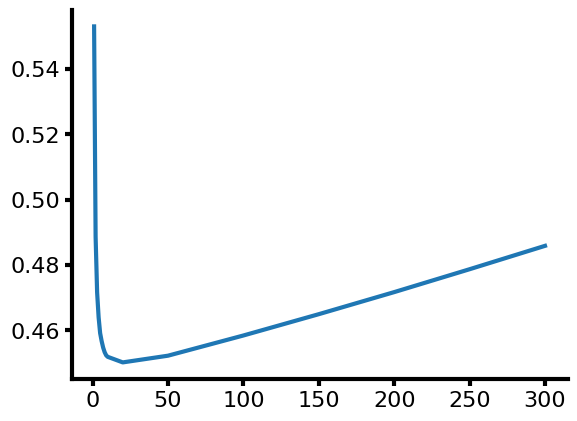

In [27]:
es = []
ees = []
for n, r in zip(ndims, rs):
    e = np.abs(((pairwise_dist(r) - rdel) / (rdel + np.eye(len(rdel))) * (1-np.eye(len(rdel)))))
    e = e[~np.eye(e.shape[0], dtype=bool)].ravel()
    print(e.max())
    ee = np.log10(e)
    es.append(e)
    ees.append(ee)

#plt.violinplot(ees);
#plt.figure()
#plt.plot(ndims, [e.max() for e in es]);
plt.plot(ndims, [e.mean() for e in es]);
#plt.plot(ndims, [e.min() for e in es]);

(array([1.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00, 8.0000e+00,
        4.0000e+00, 9.0000e+00, 2.5000e+01, 3.9000e+01, 7.3000e+01,
        1.0800e+02, 1.9700e+02, 3.0600e+02, 5.0500e+02, 8.0800e+02,
        1.4100e+03, 2.2030e+03, 3.7750e+03, 6.1670e+03, 9.7620e+03,
        1.5101e+04, 2.0364e+04, 1.8338e+04, 6.8980e+03, 2.2090e+03,
        9.7800e+02, 3.3200e+02, 6.0000e+01, 1.3000e+01, 2.0000e+00]),
 array([-5.18307972, -4.96557971, -4.74807971, -4.53057971, -4.31307971,
        -4.09557971, -3.87807971, -3.66057971, -3.44307971, -3.2255797 ,
        -3.0080797 , -2.7905797 , -2.5730797 , -2.3555797 , -2.1380797 ,
        -1.9205797 , -1.7030797 , -1.4855797 , -1.26807969, -1.05057969,
        -0.83307969, -0.61557969, -0.39807969, -0.18057969,  0.03692031,
         0.25442031,  0.47192032,  0.68942032,  0.90692032,  1.12442032,
         1.34192032]),
 <BarContainer object of 30 artists>)

findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: 

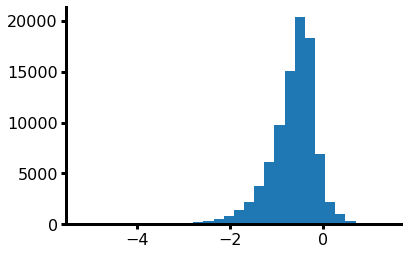

## Comparse itersparse vs sparse

In [10]:
ident1 = 'itersparse_20251202_d3_h300_lr0.001_llNone_dt0.5_ee6ef8ec-72fb-47ad-88a0-1db8cc2efe75'

In [19]:
df = dfs['sparse_epoch']
x = df[df.i == 0].sparse_iter
set(x)

{False, nan}

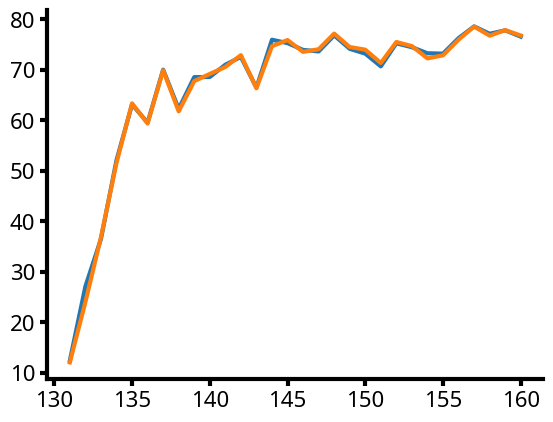

In [23]:
x = df[df.id == 'ee6ef8ec-72fb-47ad-88a0-1db8cc2efe75']
plt.plot(x.t1p)
plt.plot(x.t1p_sp)

# performance with pruning after training

In [30]:
import networks, sim, shd

In [28]:
!ls ./saved/20251203_d3_h300_lr0.001_llNone_dt0.5_a8043770-8da0-4e9d-b8d5-c3643075b9a9/

epoch_00000000.npz	 epoch_00000010_read.npz  epoch_00000021.npz
epoch_00000000_read.npz  epoch_00000011.npz	  epoch_00000021_read.npz
epoch_00000001.npz	 epoch_00000011_read.npz  epoch_00000022.npz
epoch_00000001_read.npz  epoch_00000012.npz	  epoch_00000022_read.npz
epoch_00000002.npz	 epoch_00000012_read.npz  epoch_00000023.npz
epoch_00000002_read.npz  epoch_00000013.npz	  epoch_00000023_read.npz
epoch_00000003.npz	 epoch_00000013_read.npz  epoch_00000024.npz
epoch_00000003_read.npz  epoch_00000014.npz	  epoch_00000024_read.npz
epoch_00000004.npz	 epoch_00000014_read.npz  epoch_00000025.npz
epoch_00000004_read.npz  epoch_00000015.npz	  epoch_00000025_read.npz
epoch_00000005.npz	 epoch_00000015_read.npz  epoch_00000026.npz
epoch_00000005_read.npz  epoch_00000016.npz	  epoch_00000026_read.npz
epoch_00000006.npz	 epoch_00000016_read.npz  epoch_00000027.npz
epoch_00000006_read.npz  epoch_00000017.npz	  epoch_00000027_read.npz
epoch_00000007.npz	 epoch_00000017_read.npz  epoch_00000028.np

/usr/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [33]:
fn = './saved/20251203_d3_h300_lr0.001_llNone_dt0.5_a8043770-8da0-4e9d-b8d5-c3643075b9a9/epoch_00000029.npz'
net3 = networks.NetworkWithReadout(networks.SpatialNetwork.load(None, fn), np.load(fn.replace('.npz', '_read.npz'))['w'])

In [34]:
fn = './saved/20251202_dinf_h300_lr0.001_llNone_dt0.5_8b99594b-1be6-45d5-ac71-b2ce88b6edbc/epoch_00000029.npz'
netinf = networks.NetworkWithReadout(networks.DelayNetwork.load(None, fn), np.load(fn.replace('.npz', '_read.npz'))['w'])

In [35]:
test  = shd.SHD.load('test', limit=None, skip=True)
inp_test, lbl_test   = test.indicators_labels32(idxs=jnp.arange(test.size), dt=0.5)



SKIP!


100%|█████████████████████████████████████████████████████| 2264/2264 [00:02<00:00, 764.02it/s]


In [36]:
tau_mem = 10.
sim_kwargs = {}

@jax.jit
def performance(net, in_spikes, labels):
    @jax.jit
    def get_logits(x):
        ws, v, f, a = net.sim(x, tau_mem=tau_mem, dt=0.5, **sim_kwargs)
        return ws, f
    # logits, f = jax.lax.map(get_logits, in_spikes, batch_size=64)
    logits, f = jax.vmap(get_logits)(in_spikes)
    f = f.mean(0)
    top3 = jnp.argsort(logits, axis=1)[:,-3:]
    top1p = 100 * (top3[:,-1] == labels).mean()
    top3p = 100 * (top3 == labels[:,None]).any(1).mean()
    return top1p, top3p, f
def performance_split(net, in_spikes, labels):
    BATCH_SIZE=64
    n = len(in_spikes)
    top1_list, top3_list, f_list = [], [], []
    for i in tqdm.tqdm(range(0, n, BATCH_SIZE)):
        batch_inputs = in_spikes[i:i+BATCH_SIZE]
        batch_labels = labels[i:i+BATCH_SIZE]
        top1, top3, f = performance(net, batch_inputs, batch_labels)
        top1_list.append(top1)
        top3_list.append(top3)
        f_list.extend(f)
    avg_top1 = sum(top1_list) / len(top1_list)
    avg_top3 = sum(top3_list) / len(top3_list)
    return avg_top1, avg_top3, jnp.array(f_list)

In [37]:
performance_split(net3, inp_test, lbl_test)
None

  3%|█▋                                                         | 1/36 [00:03<01:59,  3.42s/it]


KeyboardInterrupt: 

In [38]:
N = 1
o = []
for sp in [1.0, 0.9, 0.7, 0.5, 0.3, 0.2, 0.1, 0.05, 0.01]:
    spnet = networks.sparsify(net3, sp)
    a_t1p, a_t3p, a_f = performance_split(spnet, inp_test[::N], lbl_test[::N])
    spnet = networks.sparsify(netinf, sp)
    t1p, t3p, f = performance_split(spnet, inp_test[::N], lbl_test[::N])
    o.append(dict(
        sp=sp,
        d3_t1p=a_t1p,
        d3_t3p=a_t3p,
        d3_f=a_f,
        inf_t1p=t1p,
        inf_t3p=t3p,
        inf_f=f,
        ))
o = pd.DataFrame(o)
o

100%|██████████████████████████████████████████████████████████| 36/36 [00:47<00:00,  1.31s/it]


,sp,d3_t1p,d3_t3p,d3_f,inf_t1p,inf_t3p,inf_f
0,1.00,75.21702,92.7228,"[0.0010011747116616832, 0.0006874733020076891,...",68.85127,90.81308,"[0.09021919051687313, 0.0005473088423750534, 6..."
1,0.90,75.56424,93.04109,"[0.0009878257155061941, 0.0006607753096967109,...",68.43172,90.72627,"[0.08883089491670226, 0.0005606578385305425, 6..."
2,0.70,74.65278,93.11343,"[0.0011146411789833405, 0.0006340773173857325,...",63.68634,86.704285,"[0.08704880392994446, 0.0005673323366082871, 1..."
3,0.50,60.749424,84.28819,"[0.0009945002135839385, 0.0006073793250747543,...",54.296875,80.87384,"[0.07783799658265698, 0.000553983340452798, 1...."
4,0.30,53.949654,74.05961,"[0.0017620674925245621, 0.00024695642887654853...",45.572918,67.737274,"[0.05526484408372491, 0.0006674498077744555, 1..."
5,0.20,39.945026,68.34491,"[0.0018288124733020078, 6.007048269970098e-05,...",32.8125,57.942707,"[0.03557507475437847, 0.0013816211020931226, 1..."
6,0.10,21.209492,51.475697,"[0.0007208457923964118, 0.0, 0.001074594190516...",22.309029,44.039352,"[0.011072992310978216, 0.003250480563861597, 6..."
7,0.05,20.384838,48.09028,"[0.00024028193079880393, 0.0, 0.00213583938487...",15.248842,33.76736,"[0.003183735583084152, 0.0026964972234087997, ..."
8,0.01,6.915509,23.032408,"[4.672148654421188e-05, 0.0, 0.000113466467321...",7.0167828,19.343172,"[0.00046721486544211877, 0.001168037163605297,..."


1832    0.01
220     0.02
89      0.05
976     0.10
1712    0.20
130     0.30
1870    0.40
790     0.50
59      0.60
700     0.70
1146    0.90
Name: sparse, dtype: float64

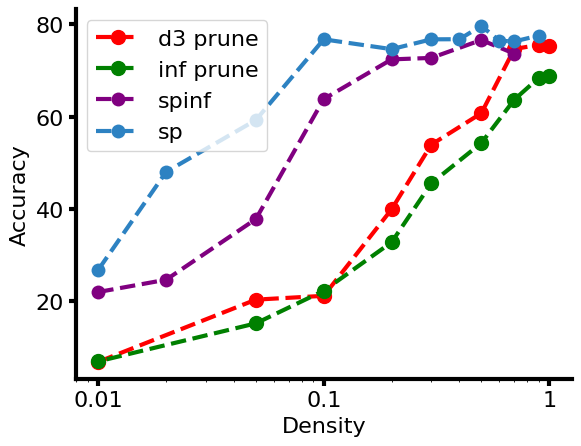

In [305]:
plt.plot(o.sp, o.d3_t1p , 'o--', label='d3 prune', color='red')
plt.plot(o.sp, o.inf_t1p, 'o--', label='inf prune', color='green')
plt.xscale('log')



x = dfs['sparse_epoch']

x = x[(x.i==29) & (x.adex != x.adex)]

a  = dfs['sparse_epoch'][(dfs['sparse_epoch'].i == 29) & dfs['sparse_epoch'].id.isin( [
'12863066-f452-442e-aec0-efc8c87fe493',
'ebcb9d83-adc3-41f2-9ac2-dae44ba2d540',
'ab360518-1b88-4074-bb77-f74508c5ef2c',
'8b381456-7a96-40ce-85d6-8e01b0b5b9f2',
'33f78f03-04bb-4155-8e33-c8b2a087295d',
'b15c9eba-89a9-4605-8c02-ccc89b297c0d',
'cb2d35a1-04b0-409b-afcc-259af08ee0a6',
'823b829f-e2d9-4d93-9c31-bd3fa26edb72'
]
)][['id', 'sparse', 't1p', 't1p_sp']]
a = a.sort_values('sparse')
plt.plot(a['sparse'], a.t1p_sp, 'o--', color='purple', markeredgecolor='none', label='spinf')


x = x.sort_values('sparse')
s = x['sparse']
# t = x.t1p
# plt.plot(s, t, 'o--', color='#1f5f8f4c', markeredgecolor='none')
ts = x.t1p_sp
plt.plot(s, ts, 'o--', color='#2d82c2ff', markeredgecolor='none', label='sp')
#plt.ylim(60, 100)
#plt.xlim(0, 1)

plt.xscale('log')
plt.xlabel('Density')
plt.ylabel('Accuracy')
plt.xticks([0.01, 0.1, 1], [0.01, 0.1, 1])
plt.legend()

plt.savefig('img/sparse_all_com.png')
plt.savefig('img/sparse_all_com.svg')
s

In [307]:
#!find saved/20251202_dinf_h300_lr0.001_llNone_dt0.5_bab14453-6133-4e0b-a1f9-cd1ff9fffdb3
#!cat saved/20251202_d3_h300_lr0.001_llNone_dt0.5_60a91ecd-ba81-4ec7-9d11-a2314ed8c9c7/log.jsons | grep epoch

epoch[(epoch.i==29) & epoch.id.isin(
[
'12863066-f452-442e-aec0-efc8c87fe493',
'823b829f-e2d9-4d93-9c31-bd3fa26edb72',
'cb2d35a1-04b0-409b-afcc-259af08ee0a6',
'ebcb9d83-adc3-41f2-9ac2-dae44ba2d540']
)][['id', 'sparse', 't1p']]

d = dfs['sparse_epoch']
d[(d.nhidden == 300)&(d.i==29)&(d.net =='inf')].id



670     12863066-f452-442e-aec0-efc8c87fe493
820     ebcb9d83-adc3-41f2-9ac2-dae44ba2d540
900     ab360518-1b88-4074-bb77-f74508c5ef2c
1036    8b381456-7a96-40ce-85d6-8e01b0b5b9f2
1116    33f78f03-04bb-4155-8e33-c8b2a087295d
1552    b15c9eba-89a9-4605-8c02-ccc89b297c0d
1632    cb2d35a1-04b0-409b-afcc-259af08ee0a6
1772    823b829f-e2d9-4d93-9c31-bd3fa26edb72
Name: id, dtype: object

# Parameter count

0
∞
2
3


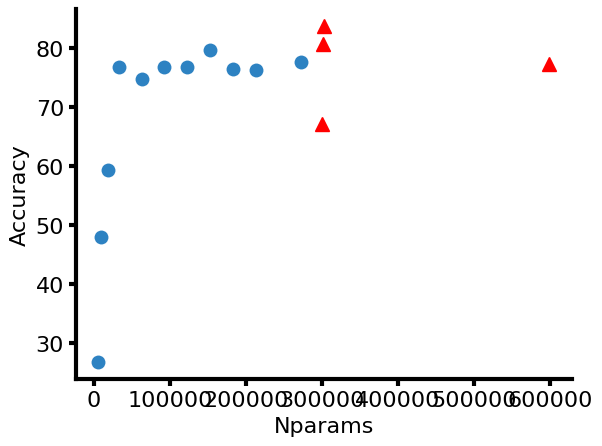

In [146]:
x = dfs['sparse_epoch']

x = x[x.i==29]
x = x[x.adex != x.adex]

x = x.sort_values('sparse')
s = x['sparse']

params =  (
    3 * 700 +
    3 * 303 +
    s * (300 * 299 +
    300 * 700)
    )

ts = x.t1p_sp

plt.plot(params, ts, 'o', color='#2d82c2ff', markeredgecolor='none')

plt.xlabel('Nparams')
plt.ylabel('Accuracy')


take = [ '0', 'inf', '2', '3' ]
finalnormal = final[(final.net.isin(take))  & (final['sparse']!= final['sparse']) &
(final.tgtfreq==10) & (final.population_freq != True) & (final.line != True) &
(final.adex != final.adex)] #& (final.tag == 'default')]

finalnormal = finalnormal[finalnormal.nhidden == 300]
#finalnormal = finalnormal[finalnormal.nhidden == 250]
for net in take:
    sub = finalnormal[finalnormal.netspec == net]
    sub = sub.sort_values('nhidden') # type: ignore
    low = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.25)
    high = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.75)
    sub = sub[['nhidden', 't1p']].groupby('nhidden').median()
    y = sub.t1p
    color = 'red'
    # if net == '0': color = 'black'
    # elif net == 'inf': color = 'blue'
    neurons = sub.index.values
    if net == '0':
        params = neurons * (neurons - 1) + 700 * neurons
    elif net == 'inf':
        params = 2 * neurons * (neurons - 1) + 2 * 700 * neurons
    else:
        params = 700 * neurons + int(net)*700 + neurons * (neurons - 1) + neurons * int(net)
    line,  = plt.plot(params, y, '^--', label=net, color=color)
    net = net.replace('inf', '∞')

    print(net)

plt.savefig('img/params_sp.png')
plt.savefig('img/params_sp.svg')

plt.xticksNee

None

## AdeX

In [309]:
x = dfs['epoch']
x[(x.net == '2') & (x.nhidden == 300)]

,id,i,t1p,t3p,t1p_train,t3p_train,net,nhidden,batch_size,load_limit,...,adex,adex_a,adex_b,adex_tau,adex_dt,vplot,pos,iadapt0,sparse_iter,plotdim
8932,9d395a0d-a55a-4990-ac97-44784d4c1328,0,21.021412,46.368637,23.783052,45.898438,2,300,32,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
8933,9d395a0d-a55a-4990-ac97-44784d4c1328,1,48.307293,73.249428,54.507210,79.822716,2,300,32,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
8934,9d395a0d-a55a-4990-ac97-44784d4c1328,2,57.132523,81.336807,71.890022,93.073921,2,300,32,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
8935,9d395a0d-a55a-4990-ac97-44784d4c1328,3,72.077553,92.896408,82.932693,97.220551,2,300,32,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
8936,9d395a0d-a55a-4990-ac97-44784d4c1328,4,73.770256,93.084496,87.920670,98.437500,2,300,32,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44017,11378be6-5245-449c-aabd-36e20880f1fc,25,77.199074,94.675926,95.417671,99.804688,2,300,32,None,...,False,0.005,0.01,200.0,0.1,False,False,0.1,NaN,2.0
44018,11378be6-5245-449c-aabd-36e20880f1fc,26,79.730904,94.010414,95.808296,99.414062,2,300,32,None,...,False,0.005,0.01,200.0,0.1,False,False,0.1,NaN,2.0
44019,11378be6-5245-449c-aabd-36e20880f1fc,27,79.079865,95.052086,95.417671,99.609375,2,300,32,None,...,False,0.005,0.01,200.0,0.1,False,False,0.1,NaN,2.0
44020,11378be6-5245-449c-aabd-36e20880f1fc,28,78.313080,93.894676,96.153847,99.804688,2,300,32,None,...,False,0.005,0.01,200.0,0.1,False,False,0.1,NaN,2.0


,id,nhidden,t1p
28924,99d41914-3768-4ad5-8fe4-7bbeb9c1f1b4,10,54.774307
35198,269ed9b4-ab29-467e-aaf0-61c7a58a961d,30,58.506947
38863,3b408a12-b7df-44eb-b92e-810c74018177,50,55.801502
13249,f0132f51-27fa-47ef-9785-385500542f8d,70,60.850697
39321,34324938-b55a-498b-a1d1-10cfcaf8f675,100,59.649883


,id,nhidden,t1p
17538,e585492a-ae86-472a-b189-7d57049bf8b8,10,41.493057
18128,bbc86a62-4c17-4504-a398-d0e1d0af0659,30,59.505207
30604,469730a9-b077-4ea1-9ac5-6556cdd9487e,50,59.649883
29797,0148ec74-0324-40bd-8ffc-33f901c008c5,70,47.960072
29164,b2618042-482b-4ba0-8f7c-db584cc04ba0,100,48.625580


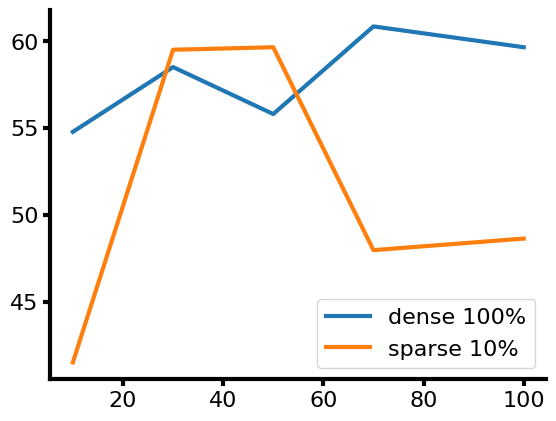

In [310]:
y = x[(x.adex == True) & (x.i == 99) & (x['sparse'] == 1.0)]
y = y.sort_values('nhidden')
display(y[['id', 'nhidden', 't1p']])
y = y[['nhidden', 't1p']]
y = y.groupby('nhidden').mean()
plt.plot(y.index, y.t1p, label='dense 100%')

y = x[(x.adex == True) & (x.i == 99) & (x['sparse'] == 0.1)]
y = y.sort_values('nhidden')
display(y[['id', 'nhidden', 't1p']])
y = y[['nhidden', 't1p']]
y = y.groupby('nhidden').mean()
plt.plot(y.index, y.t1p, label='sparse 10%')

plt.legend()

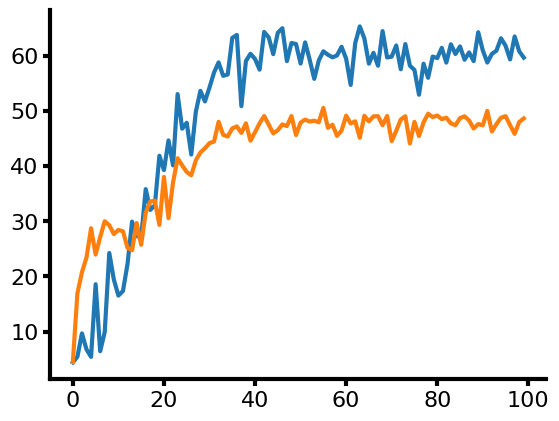

In [67]:
# y = x[x.id == 'a5c9d2e3-19b2-43e2-8e9a-b4d478ce3374']
# y = x[x.id == '2a3ba080-f76f-4ac9-ad59-eb61c45bd72a']
y = x[x.id == '34324938-b55a-498b-a1d1-10cfcaf8f675']
plt.plot(y.i, y.t1p)

#y = x[x.id == '77237c9a-a2d5-45ec-b2eb-3325cdea2cad']
y = x[x.id == 'b2618042-482b-4ba0-8f7c-db584cc04ba0']
plt.plot(y.i, y.t1p)

# AdEx plots

In [68]:
ident = '1fdc613f-c71a-43bc-9388-b0856006c478'
ident = '0ce26bee-b62f-4fe0-acc2-181fe5b30243'

!find -wholename '*'{ident}'*/*29.npz'

/usr/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


./saved/adex_20251202_d3_h30_lr0.001_llNone_dt0.5_0ce26bee-b62f-4fe0-acc2-181fe5b30243/epoch_00000029.npz


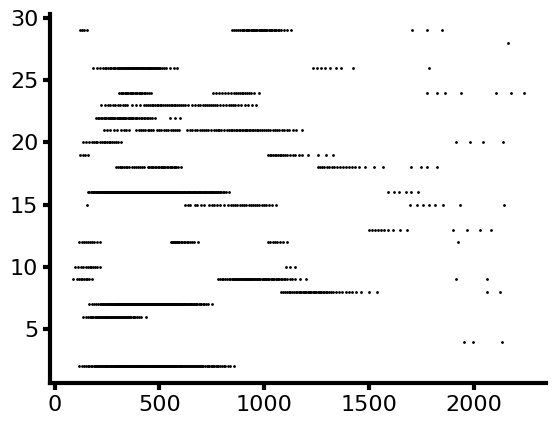

In [140]:
# fn = './saved/adex_20251202_d3_h30_lr0.001_llNone_dt0.5_0ce26bee-b62f-4fe0-acc2-181fe5b30243/epoch_00000029.npz'
fn = './saved/20251113_d3_h30_lr0.001_llNone_dt0.5_bfd440fc-ea21-4d2e-9b04-c05e4f48e35a/epoch_00000029.npz'
#fn = './saved/adex_sparse_20251202_d3_h30_lr0.001_llNone_dt0.5_1fdc613f-c71a-43bc-9388-b0856006c478/epoch_00000029.npz'
net = networks.NetworkWithReadout(networks.SpatialNetwork.load(None, fn), np.load(fn.replace('.npz', '_read.npz'))['w'])




sim_kwargs = { }
if 'adex' in fn:
    sim_kwargs['model'] = 'adex'
    sim_kwargs['adex_a'] = 0.005
    sim_kwargs['adex_b'] = 0.01
    sim_kwargs['adex_tau'] = 200
    sim_kwargs['adex_DT'] = 0.1
    sim_kwargs['iadapt0'] = 0.1

out, v, f, a = net.sim(inp_test[1], **sim_kwargs)
importance = np.abs(net.w).sum(0)
importance = importance.argsort()

for i in range(v.shape[1]):
    j = importance[i]
    vv = v[:, i]
    vv =vv.at[vv< -1].set(-1)
    ts = np.where(vv >= 1)[0]
    plt.scatter(ts, 0*ts + j, s=1, color='black')

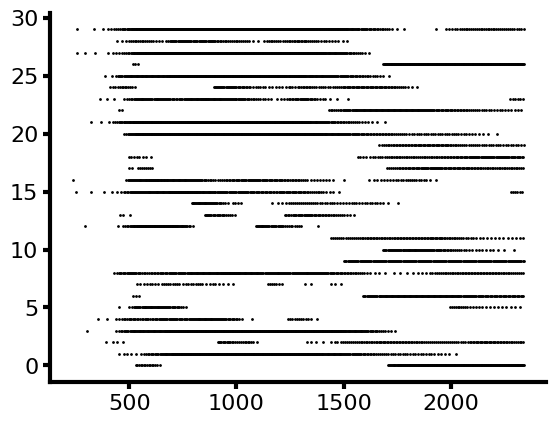

In [219]:
fn = './saved/adex_20251202_d3_h30_lr0.001_llNone_dt0.5_0ce26bee-b62f-4fe0-acc2-181fe5b30243/epoch_00000029.npz'
#fn = './saved/20251113_d3_h30_lr0.001_llNone_dt0.5_bfd440fc-ea21-4d2e-9b04-c05e4f48e35a/epoch_00000029.npz'
#fn = './saved/adex_sparse_20251202_d3_h30_lr0.001_llNone_dt0.5_1fdc613f-c71a-43bc-9388-b0856006c478/epoch_00000029.npz'
net = networks.NetworkWithReadout(networks.SpatialNetwork.load(None, fn), np.load(fn.replace('.npz', '_read.npz'))['w'])


IDX = 2
sim_kwargs = { }
if 'adex' in fn:
    sim_kwargs['model'] = 'adex'
    sim_kwargs['adex_a'] = 0.005
    sim_kwargs['adex_b'] = 0.01
    sim_kwargs['adex_tau'] = 200
    sim_kwargs['adex_DT'] = 0.1
    sim_kwargs['iadapt0'] = 0.1

out, v, f, a = net.sim(inp_test[IDX], **sim_kwargs)
importance = np.abs(net.w).sum(0)
importance = importance.argsort()

for i in range(v.shape[1]):
    j = importance[i]
    vv = v[:, i]
    vv =vv.at[vv< -1].set(-1)
    ts = np.where(vv >= 1)[0]
    plt.scatter(ts, 0*ts + j, s=1, color='black')

#for i in jnp.where(net.w[lbl_test[1]] > 0)[0]:
    


(np.float64(-53.27268436152914),
 np.float64(84.23761872417498),
 np.float64(-36.7744260764547),
 np.float64(52.6165053228932))

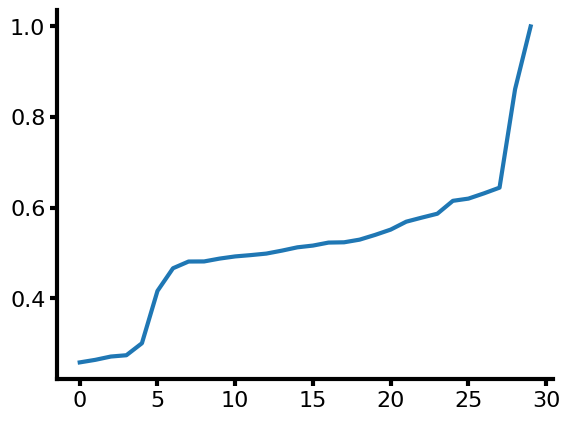

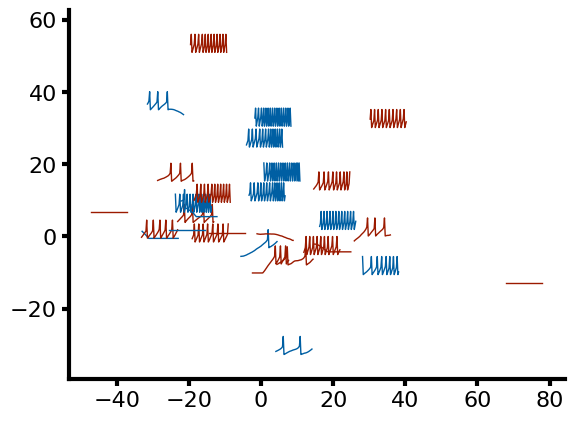

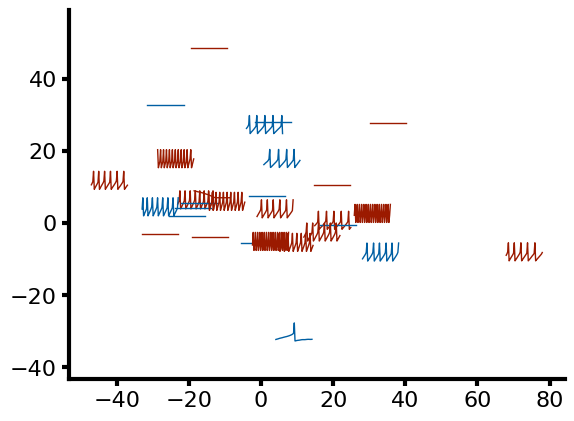

In [218]:
x, y, z = net.net.rpos.T
#plt.scatter(x, y)

from matplotlib.colors import LinearSegmentedColormap

aa = 0.5

bottom = '#9b1a00ff'   # stronger red
mid    = 'gray'
top    = '#005fa3ff'   # stronger blue


cmap = LinearSegmentedColormap.from_list(
    'custom_sat',
    [bottom, mid, top]
)


contrib = jnp.abs(net.w).sum(0)
#contrib = contrib.argsort() / (len(contrib)-1)
contrib = contrib / contrib.max()

plt.plot(sorted(contrib))

plt.figure()

for i in range(30):
    u = v[500:550:,i]
    u = u.at[u < -1].set(-1)
    u = u.at[u > 1].set(2)
    c = cmap(contrib[i])
    c = bottom if contrib[i] > 0.5 else top
    plt.plot(x[i] + aa*10*np.linspace(-1, 1, len(u)), y[i] + aa*5*u-1, color=c, lw=1)
plt.axis('equal')

plt.figure()



for i in range(30):
    u = v[2000:2050:,i]
    u = u.at[u < -1].set(-1)
    u = u.at[u > 1].set(2)
    c = cmap(contrib[i])
    c = bottom if contrib[i] > 0.5 else top
    plt.plot(x[i] + aa*10*np.linspace(-1, 1, len(u)), y[i] + aa*5*u-1, color=c, lw=1)
plt.axis('equal')

In [242]:
fn0 = './saved/adex_20251202_d3_h30_lr0.001_llNone_dt0.5_0ce26bee-b62f-4fe0-acc2-181fe5b30243/epoch_00000000.npz'
#fn = './saved/20251113_d3_h30_lr0.001_llNone_dt0.5_bfd440fc-ea21-4d2e-9b04-c05e4f48e35a/epoch_00000029.npz'
#fn = './saved/adex_sparse_20251202_d3_h30_lr0.001_llNone_dt0.5_1fdc613f-c71a-43bc-9388-b0856006c478/epoch_00000029.npz'
net0 = networks.NetworkWithReadout(networks.SpatialNetwork.load(None, fn0), np.load(fn0.replace('.npz', '_read.npz'))['w'])


IDX = 2
sim_kwargs = { }
if 'adex' in fn0:
    sim_kwargs['model'] = 'adex'
    sim_kwargs['adex_a'] = 0.005
    sim_kwargs['adex_b'] = 0.01
    sim_kwargs['adex_tau'] = 200
    sim_kwargs['adex_DT'] = 0.1
    sim_kwargs['iadapt0'] = 0.1

out, v0, f0, a0 = net.sim(inp_test[IDX], **sim_kwargs)




In [ ]:
IDX = 6
plt.plot(v0[:,IDX])
plt.plot(a0[:,IDX])
#plt.xlim(300, 600)
plt.ylim(-2, 2)

In [314]:
!ls saved -t | grep 20251204

sparse_20251204_dinf_h300_lr0.001_llNone_dt0.5_ab360518-1b88-4074-bb77-f74508c5ef2c
sparse_20251204_dinf_h300_lr0.001_llNone_dt0.5_b15c9eba-89a9-4605-8c02-ccc89b297c0d
sparse_20251204_dinf_h300_lr0.001_llNone_dt0.5_8b381456-7a96-40ce-85d6-8e01b0b5b9f2
sparse_20251204_dinf_h300_lr0.001_llNone_dt0.5_33f78f03-04bb-4155-8e33-c8b2a087295d
adex_itersparse_20251204_d3_h100_lr0.001_llNone_dt0.5_1254f7db-9323-4e30-bd9f-363b3ab7040e
adex_itersparse_20251204_d2_h100_lr0.001_llNone_dt0.5_8eb43a6c-f36a-45df-af20-1e3253cc1874
adex_20251204_d3_h100_lr0.001_llNone_dt0.5_4af24feb-4d36-4d84-98f1-ab3b931c30fa
adex_20251204_d2_h100_lr0.001_llNone_dt0.5_abf524c3-13fd-4747-98d6-fd48d8523661
adex_itersparse_20251204_d3_h50_lr0.001_llNone_dt0.5_49e79a0b-0746-4b99-b7b2-82cfd14ebdcb
adex_itersparse_20251204_d2_h50_lr0.001_llNone_dt0.5_32843f31-8b95-4500-bc2c-ff291ef5d125
adex_20251204_d3_h50_lr0.001_llNone_dt0.5_3cf6fe83-aade-4bb8-bf03-b901e138a011
adex_20251204_d2_h50_lr0.001_llNone_dt0.5_4c65c2d2-776d-4223-81

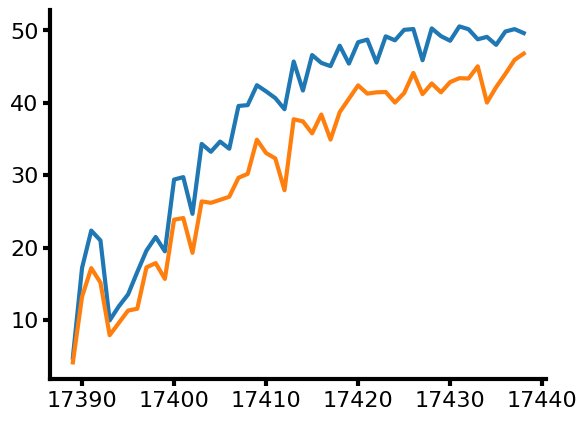

In [323]:
ident = 'adex_itersparse_20251204_d3_h100_lr0.001_llNone_dt0.5_1254f7db-9323-4e30-bd9f-363b3ab7040e'
ident = 'adex_20251204_d3_h100_lr0.001_llNone_dt0.5_4af24feb-4d36-4d84-98f1-ab3b931c30fa'
ident = 'adex_itersparse_20251204_d3_h50_lr0.001_llNone_dt0.5_49e79a0b-0746-4b99-b7b2-82cfd14ebdcb'

x = dfs['epoch']
x = x[x.id == ident.split('_')[-1]]
plt.plot(x.t1p)
plt.plot(x.t1p_train)